# Notebook to plot the fairness and performance metrics

# Import Libraries

In [1]:
#import libraries
import numpy as np
import os
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean

In [2]:
try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  import sys
  path_to_project = '/content/drive/MyDrive/FairAlgorithm'
  sys.path.append(path_to_project)
  !sudo apt install libcairo2-dev pkg-config python3-dev
  IN_COLAB = True
except:
  IN_COLAB = False

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libblkid-dev libblkid1 libcairo-script-interpreter2 libffi-dev
  libglib2.0-dev libglib2.0-dev-bin libice-dev liblzo2-2 libmount-dev
  libmount1 libpixman-1-dev libselinux1-dev libsepol-dev libsm-dev
  libxcb-render0-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libgdk-pixbuf2.0-bin
  | libgdk-pixbuf2.0-dev libxml2-utils libice-doc cryptsetup-bin libsm-doc
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libblkid-dev libcairo-script-interpreter2 

In [3]:
from source.utils.config import *

# Configure Notebook

In [4]:
dataset_list = ['diabetes-women'] #options: "diabetes-women", "sepsis", 'aids', "myocardial-infarction", 'alzheimer-disease', "diabetes-prediction", "stroke-prediction"
#perf_metrics = ['accuracy', 'precision', 'recall', 'f1_score']
#dataset_name = 'diabetes-women'
#sensible_attribute = 'AgeCategory'

In [5]:
#dataset_list = datasets_config.keys()
metrics = fairness_catalogue
perf_metrics = performance_metrics

# dataset_config = datasets_config[dataset_name]
# ignore_cols = dataset_config['ignore_cols']
# target_variable = dataset_config['target_variable']
# target_variable_labels = dataset_config['target_variable_labels']
# sensible_attributes = dataset_config['sensible_attributes']
# default_mappings = dataset_config.get('default_mappings', {})



# Load Metrics

In [6]:
# Load the metrics results
def load_metrics(dataset_name, sensible_attribute, mitigation):
  load_path = path_to_project + '/measurements/metrics-{}-{}-{}.p'.format(dataset_name, sensible_attribute, mitigation)
  with open(load_path, 'rb') as fp:
      mitigation_metrics = pickle.load(fp)
  return mitigation_metrics

def load_performance_metrics(dataset_name, sensible_attribute, mitigation):
  load_path = path_to_project + '/measurements/performance_metrics-{}-{}-{}.p'.format(dataset_name, sensible_attribute, mitigation)
  with open(load_path, 'rb') as fp:
      performance_metrics = pickle.load(fp)
  return performance_metrics

def load_original_performance_metrics(dataset_name, sensible_attribute):
  load_path = path_to_project + '/measurements/performance_metrics-{}-{}-original.p'.format(dataset_name, sensible_attribute)
  with open(load_path, 'rb') as fp:
      performance_metrics = pickle.load(fp)
  return performance_metrics

def load_original_metrics(dataset, sensible_attribute):
  load_path = path_to_project + '/measurements/metrics-{}-{}-original.p'.format(dataset, sensible_attribute)
  with open(load_path, 'rb') as fp:
      original_metrics = pickle.load(fp)
  return original_metrics

In [7]:
def load_array_metrics(dataset_list, all_mitigations, preprocessing_mitigation_list, inprocessing_mitigation_list, postprocessing_mitigation_list):
  overall_metrics = {}
  preprocessing_metrics = {}
  inprocessing_metrics = {}
  postprocessing_metrics = {}
  performance_metrics= {}

  # Load metrics for all datasets and mitigations
  for dataset in dataset_list:
    overall_metrics[dataset] = {}
    preprocessing_metrics[dataset]= {}
    inprocessing_metrics[dataset] = {}
    postprocessing_metrics[dataset] = {}
    performance_metrics[dataset] = {}
    for sensible_attribute in datasets_config[dataset]['sensible_attributes']:
      ds_metrics = {}
      pre_metrics = {}
      in_metrics = {}
      post_metrics = {}
      perf_metrics = {}
      print(dataset)
      for mitigation in all_mitigations:
        ds_metrics[mitigation] = load_metrics(dataset, sensible_attribute, mitigation)
        perf_metrics[mitigation] = load_performance_metrics(dataset, sensible_attribute, mitigation)
      print('pre')
      for mitigation in preprocessing_mitigation_list:
        pre_metrics[mitigation] = load_metrics(dataset, sensible_attribute, mitigation)
      print('in')
      for mitigation in inprocessing_mitigation_list:
        in_metrics[mitigation] = load_metrics(dataset, sensible_attribute, mitigation)
      print('post')
      for mitigation in postprocessing_mitigation_list:
        post_metrics[mitigation] = load_metrics(dataset, sensible_attribute, mitigation)

      overall_metrics[dataset][sensible_attribute] = ds_metrics
      preprocessing_metrics[dataset][sensible_attribute] = pre_metrics
      inprocessing_metrics[dataset][sensible_attribute] = in_metrics
      postprocessing_metrics[dataset][sensible_attribute] = post_metrics
      performance_metrics[dataset][sensible_attribute] = perf_metrics
      print('metrics mitigation loaded')
      original_metrics = load_original_metrics(dataset, sensible_attribute)

      overall_metrics[dataset][sensible_attribute]['original'] = original_metrics
      preprocessing_metrics[dataset][sensible_attribute]['original'] = original_metrics
      postprocessing_metrics[dataset][sensible_attribute]['original'] = original_metrics
      performance_metrics[dataset][sensible_attribute]['original'] = load_original_performance_metrics(dataset, sensible_attribute)
      for m in models:
        print(m)
        orig_metrics = {}
        orig_metrics['division'] = original_metrics['division'][m]
        orig_metrics['subtraction'] = original_metrics['subtraction'][m]
        inprocessing_metrics[dataset][sensible_attribute]['orig-'+str(m)] = orig_metrics
        #inprocessing_metrics[dataset][m]['division'] = original_metrics['division'][m]
        #inprocessing_metrics[dataset][m]['subtraction'] = original_metrics['subtraction'][m]
      print('original metrics  loaded')

  return overall_metrics, preprocessing_metrics, inprocessing_metrics, postprocessing_metrics, performance_metrics


# Plotting functions
Grouped bar chart with full results for one mitigation.

In [8]:
def map_mitigation(mitigation):
  mit_dict = {
      'original': 'OR',
      'aif360-ad': 'AD',
      'aif360-di': 'DI',
      'aif360-lfr' : 'LF',
      'aif360-op': 'OP',
      'fl-cr': 'CR',
      'fl-to': 'TO',
      'aif360-rw': 'RW',
      'aif360-pr': 'PR',
      'aif360-er': 'ER',
      'aif360-ce': 'CE',
      'aif360-eo': 'EO',
      'aif360-roc': 'RO',
      'orig-Logistic Regression': 'oLORE',
      'orig-Bagging': 'oBAGG',
      'orig-Random Forest': 'oRAFO',
      'orig-Extremely Randomized Trees': 'oEXRT',
      'orig-Decision Tree': 'oDETR',
      'orig-Ada Boost': 'oADBO'

  }
  return mit_dict[mitigation]

def map_metric(metric):
  met_dict = {
      'GroupFairness': 'GFA',
      'EqualizedOdds': 'EOD',
      'PredictiveParity': 'PPA',
      'PredictiveEquality': 'PEQ',
      'EqualOpportunity': 'EOP',
      'ConditionalUseAccuracyEquality': 'CUA',
      'OverallAccuracyEquality': 'OAE',
      'TreatmentEquality': 'TEQ',
      'FORParity': 'FOR',
      'FN': 'FNP',
      'FP': 'FPP'
  }
  return met_dict[metric]


In [9]:
def perf_grouped_bar(metrics_dict, mitigation_list, model, mitigation_category, dataset_name, sensible_attribute):
  bars_per_group = len(perf_metrics)
  num_groups = len(mitigation_list)

  data = []
  for mitigation in mitigation_list:
    l = []
    for metric in perf_metrics:
      l.append(metrics_dict[mitigation][metric][model][0])
    data.append(l)

  data = np.asarray(data)
  data = data.reshape((num_groups, bars_per_group))

  # Set up bar positions
  bar_width = 0.1
  bar_positions = np.arange(bars_per_group)

  plt.figure(figsize=(12, 6))

  # Plot the vertical bar plot
  for i in range(num_groups):
      plt.bar(bar_positions + i*bar_width,
              data[i],
              width=bar_width,
              label=mitigation_list[i])

  # Add labels and title
  plt.xlabel('Perfomance Metrics')
  plt.ylabel('Perfomance Values')
  plt.title(dataset_name+' '+sensible_attribute+' '+model+' '+mitigation_category)

  plt.xticks(bar_positions + bar_width, perf_metrics, rotation=45, ha='right')
  plt.legend()

  model_no_spaces = model.replace(" ", "")
  configuration = f"{dataset_name}-{sensible_attribute}/performance"
  file_name = f"{mitigation_category}-{model_no_spaces}.png"

  path = os.path.join(path_to_project,'plots', configuration, file_name )
  plt.savefig(path, bbox_inches="tight")

  # Show the plot
  plt.show()

In [10]:
def perf_grouped_bar_no_model(metrics_dict, mitigation_list, mitigation_category):
  bars_per_group = len(perf_metrics)
  num_groups = len(mitigation_list)

  data = []
  for mitigation in mitigation_list:
    l = []
    for metric in perf_metrics:
      l.append(metrics_dict[mitigation][metric][0])
    data.append(l)

  data = np.asarray(data)
  data = data.reshape((num_groups, bars_per_group))

  # Set up bar positions
  bar_width = 0.1
  bar_positions = np.arange(bars_per_group)

  plt.figure(figsize=(12, 6))

  # Plot the vertical bar plot
  for i in range(num_groups):
      plt.bar(bar_positions + i*bar_width,
              data[i],
              width=bar_width,
              label=mitigation_list[i])
  # Add red threshold lines
  threshold_high = 0.15
  threshold_low = -0.15
  plt.axhline(y=threshold_high, color='red', linestyle='--')
  plt.axhline(y=threshold_low, color='red', linestyle='--')

  # Add labels and title
  plt.xlabel('Performance Metrics')
  plt.ylabel('Performance Metric Values')
  plt.title(dataset_name+' '+mitigation_category)

  plt.xticks(bar_positions + bar_width, perf_metrics, rotation=45, ha='right')
  plt.legend()

  configuration = f"{dataset_name}-{sensible_attribute}/performance"
  file_name = f"{mitigation_category}.png"
  path = os.path.join(path_to_project,'plots',configuration, file_name )
  plt.savefig(path,  bbox_inches="tight")

  # Show the plot
  plt.show()

In [11]:
def grouped_bar(metrics_dict, mitigation_list, comparison, model, mitigation_category, dataset_name, sensible_attribute):
  bars_per_group = len(metrics)
  num_groups = len(mitigation_list)

  data = []
  for mitigation in mitigation_list:
    l = []
    for metric in metrics:
      l.append(metrics_dict[mitigation][comparison][model][metric][0])
    data.append(l)

  #print(data)
  data = np.asarray(data)
  data = data.reshape((num_groups, bars_per_group))

  # Set up bar positions
  bar_width = 0.1
  bar_positions = np.arange(bars_per_group)

  plt.figure(figsize=(12, 6))

  # Plot the vertical bar plot
  for i in range(num_groups):
      plt.bar(bar_positions + i*bar_width,
              data[i],
              width=bar_width,
              label=map_mitigation(mitigation_list[i]))

  # Add red threshold lines
  threshold_high = 0.15
  threshold_low = -0.15

  # Add labels and title with increased font size and bold text
  plt.xlabel('Fairness Metrics', fontsize=14)
  plt.ylabel('Fairness Metric Values', fontsize=14)
  plt.title(f"{dataset_name} {sensible_attribute} {model} {comparison} {mitigation_category}", fontsize=16, fontweight='bold')

  # Map metrics and set x-ticks
  mapped_metrics = list(map(map_metric, metrics))
  plt.xticks(bar_positions + bar_width, mapped_metrics, rotation=45, ha='right', fontsize=14)

  # Adjust legend font size and weight
  plt.legend(fontsize=12)
  plt.axhline(y=threshold_high, color='red', linestyle='--') #, label='Threshold (+0.15)')
  plt.axhline(y=threshold_low, color='red', linestyle='--') #, label='Threshold (-0.15)')

  #mapped_metrics = map(map_metric, metrics)
  #plt.xticks(bar_positions + bar_width, mapped_metrics, rotation=45, ha='right')
  #plt.legend()

  model_no_spaces = model.replace(" ", "")
  configuration = f"{dataset_name}-{sensible_attribute}"

  png_file_name = f"{mitigation_category}-{model_no_spaces}-{comparison}.png"
  pdf_file_name = f"{mitigation_category}-{model_no_spaces}-{comparison}.pdf"
  png_path = os.path.join(path_to_project, 'plots', configuration, png_file_name)
  pdf_path = os.path.join(path_to_project, 'plots', configuration, pdf_file_name)

  plt.savefig(png_path, bbox_inches="tight")
  plt.savefig(pdf_path, bbox_inches="tight")
  #plt.savefig(path, bbox_inches="tight")

  # Show the plot
  plt.show()

In [12]:
def grouped_bar_std_dev(metrics_dict, mitigation_list, comparison, model, mitigation_category, dataset_name, sensible_attribute):
  bars_per_group = len(metrics)
  num_groups = len(mitigation_list)

  data = []
  errors = []
  for mitigation in mitigation_list:
    l = []
    e = []
    for metric in metrics:
      l.append(metrics_dict[mitigation][comparison][model][metric][0])
      e.append(metrics_dict[mitigation][comparison][model][metric][1])  # Standard deviation
    data.append(l)
    errors.append(e)

  #print(data)
  data = np.asarray(data)
  errors = np.asarray(errors)
  data = data.reshape((num_groups, bars_per_group))
  errors = errors.reshape((num_groups, bars_per_group))

  # Set up bar positions
  bar_width = 0.1
  bar_positions = np.arange(bars_per_group)

  plt.figure(figsize=(12, 6))

  # Plot the vertical bar plot
  for i in range(num_groups):
      plt.bar(bar_positions + i*bar_width,
              data[i],
              yerr=errors[i],  # Adding standard deviation as error bars
              capsize=5,  # Error bar caps
              width=bar_width,
              label=map_mitigation(mitigation_list[i]))

  # Add red threshold lines
  threshold_high = 0.15
  threshold_low = -0.15

  # Add labels and title with increased font size and bold text
  plt.xlabel('Fairness Metrics', fontsize=14)
  plt.ylabel('Fairness Metric Values', fontsize=14)
  plt.title(f"{dataset_name} {sensible_attribute} {model} {comparison} {mitigation_category}", fontsize=16, fontweight='bold')

  # Map metrics and set x-ticks
  mapped_metrics = list(map(map_metric, metrics))
  plt.xticks(bar_positions + bar_width, mapped_metrics, rotation=45, ha='right', fontsize=14)

  # Adjust legend font size and weight
  plt.legend(fontsize=12)
  plt.axhline(y=threshold_high, color='red', linestyle='--') #, label='Threshold (+0.15)')
  plt.axhline(y=threshold_low, color='red', linestyle='--') #, label='Threshold (-0.15)')

  #mapped_metrics = map(map_metric, metrics)
  #plt.xticks(bar_positions + bar_width, mapped_metrics, rotation=45, ha='right')
  #plt.legend()

  model_no_spaces = model.replace(" ", "")
  configuration = f"{dataset_name}-{sensible_attribute}"

  png_file_name = f"{mitigation_category}-{model_no_spaces}-{comparison}.png"
  pdf_file_name = f"{mitigation_category}-{model_no_spaces}-{comparison}.pdf"
  png_path = os.path.join(path_to_project, 'plots', configuration, png_file_name)
  pdf_path = os.path.join(path_to_project, 'plots', configuration, pdf_file_name)

  #plt.savefig(png_path, bbox_inches="tight")
  #plt.savefig(pdf_path, bbox_inches="tight")
  #plt.savefig(path, bbox_inches="tight")

  # Show the plot
  plt.show()

In [13]:
def grouped_bar_no_model(metrics_dict, mitigation_list, comparison, mitigation_category, dataset_name, sensible_attribute ):
  bars_per_group = len(metrics)
  num_groups = len(mitigation_list)

  data = []
  for mitigation in mitigation_list:
    l = []
    for metric in metrics:
      l.append(metrics_dict[mitigation][comparison][metric][0])
    data.append(l)

  data = np.asarray(data)
  data = data.reshape((num_groups, bars_per_group))

  # Set up bar positions
  bar_width = 0.1
  bar_positions = np.arange(bars_per_group)

  plt.figure(figsize=(12, 6))

  # Plot the vertical bar plot
  for i in range(num_groups):
      plt.bar(bar_positions + i*bar_width,
              data[i],
              width=bar_width,
              label=map_mitigation(mitigation_list[i]))
  # Add red threshold lines
  plt.legend(fontsize=12, ncol=2)
  threshold_high = 0.15
  threshold_low = -0.15
  plt.axhline(y=threshold_high, color='red', linestyle='--')
  plt.axhline(y=threshold_low, color='red', linestyle='--')

  # Add labels and title
  plt.xlabel('Fairness Metrics', fontsize=14)
  plt.ylabel('Fairness Metric Values', fontsize=14)
  plt.title(dataset_name+' '+sensible_attribute+' '+comparison+' '+mitigation_category, fontsize=16, fontweight='bold')

  mapped_metrics = map(map_metric, metrics)
  plt.xticks(bar_positions + bar_width, mapped_metrics, rotation=45, ha='right',  fontsize=14)
  #plt.xticks(bar_positions + bar_width, metrics, rotation=45, ha='right')
  plt.legend(fontsize=12, loc='lower left', bbox_to_anchor=(0, 0))

  configuration = f"{dataset_name}-{sensible_attribute}"
  #file_name = f"{mitigation_category}-{comparison}.png"
  png_file_name = f"{mitigation_category}-{comparison}.png"
  pdf_file_name = f"{mitigation_category}-{comparison}.pdf"
  png_path = os.path.join(path_to_project, 'plots', configuration, png_file_name)
  pdf_path = os.path.join(path_to_project, 'plots', configuration, pdf_file_name)
  plt.savefig(png_path, bbox_inches="tight")
  plt.savefig(pdf_path, bbox_inches="tight")
  #path = os.path.join(path_to_project,'plots',configuration, file_name )
  #plt.savefig(path,  bbox_inches="tight")

  # Show the plot
  plt.show()

# Table function

In [14]:
def data_framing(dictionary, dataset, sensible_attribute, comparison, model, mitigation_list):
  # Define the columns for your DataFrame
  columns = ['Mitigation'] + metrics

  # Create an empty DataFrame with the specified columns
  data = pd.DataFrame(columns=columns)

  for mitigation in mitigation_list:
    l = []
    l.append(mitigation)
    for metric in metrics:
      l.append(dictionary[dataset][sensible_attribute][mitigation][comparison][model][metric][0])
    row_df = pd.DataFrame([l], columns=columns)
    data = pd.concat([data, row_df], ignore_index=True)

  data.set_index('Mitigation', inplace=True)
  return data

In [15]:
def perf_data_framing(dictionary, dataset, sensible_attribute, model, mitigation_list):
  # Define the columns for your DataFrame
  columns = ['Mitigation'] + perf_metrics

  # Create an empty DataFrame with the specified columns
  data = pd.DataFrame(columns=columns)

  for mitigation in mitigation_list:
    l = []
    l.append(mitigation)
    for metric in perf_metrics:
      if model is not None:
        l.append(f"{dictionary[dataset][sensible_attribute][mitigation][metric][model][0]:.3f}+/-{dictionary[dataset][sensible_attribute][mitigation][metric][model][1]:.3f}")
      else:
        l.append(f"{dictionary[dataset][sensible_attribute][mitigation][metric][0]:.3f}+/-{dictionary[dataset][sensible_attribute][mitigation][metric][1]:.3f}")
    row_df = pd.DataFrame([l], columns=columns)
    data = pd.concat([data, row_df], ignore_index=True)

  data.set_index('Mitigation', inplace=True)
  return data

#Load metrics

In [16]:
overall_metrics, preprocessing_metrics, inprocessing_metrics, postprocessing_metrics, performance_metrics = load_array_metrics(dataset_list, all_mitigations, preprocessing_mitigation_list, inprocessing_mitigation_list, postprocessing_mitigation_list)

diabetes-women
pre
in
post
metrics mitigation loaded
Logistic Regression
Decision Tree
Bagging
Random Forest
Extremely Randomized Trees
Ada Boost
original metrics  loaded


In [17]:
print(overall_metrics)

{'diabetes-women': {'AgeCategory': {'fl-cr': {'division': {'Logistic Regression': {'GroupFairness': [0.4255968850704354, 0.06268167669415], 'PredictiveParity': [0.24678411804485548, 0.09969425674561977], 'PredictiveEquality': [0.3850480121873311, 0.4084879868296354], 'EqualOpportunity': [-0.9170963995354239, 0.11879493650485985], 'EqualizedOdds': [0.46882205513784464, 0.33705821673463543], 'ConditionalUseAccuracyEquality': [0.29745009802760564, 0.2604240778377748], 'OverallAccuracyEquality': [0.24369834554120504, 0.09202281499717122], 'TreatmentEquality': [-0.8667019400352733, 0.16787219822141444], 'FORParity': [-0.3866666666666666, 0.7523592522488473], 'FN': [-0.8816828291600327, 0.16366307694785157], 'FP': [-0.4755882712519462, 0.29829024836610735]}, 'Decision Tree': {'GroupFairness': [0.5285147886220622, 0.21253583828990366], 'PredictiveParity': [0.2803378202454997, 0.13281871370953238], 'PredictiveEquality': [0.6353333333333332, 0.19559233832589507], 'EqualOpportunity': [-0.6574994

In [18]:
# print(preprocessing_metrics)
# print("mean:"+str(preprocessing_metrics['diabetes-women']['AgeCategory']['aif360-di']['division']['Logistic Regression']['GroupFairness'][0]))
# print("std dev:"+str(preprocessing_metrics['diabetes-women']['AgeCategory']['aif360-di']['division']['Logistic Regression']['GroupFairness'][1]))

# Preprocessing results

In [19]:
print(preprocessing_mitigation_list)

['fl-cr', 'aif360-rw', 'aif360-di', 'aif360-lfr', 'aif360-op']


In [20]:
preprocessing_mitigation_list.insert(0, 'original')

### Performance metrics

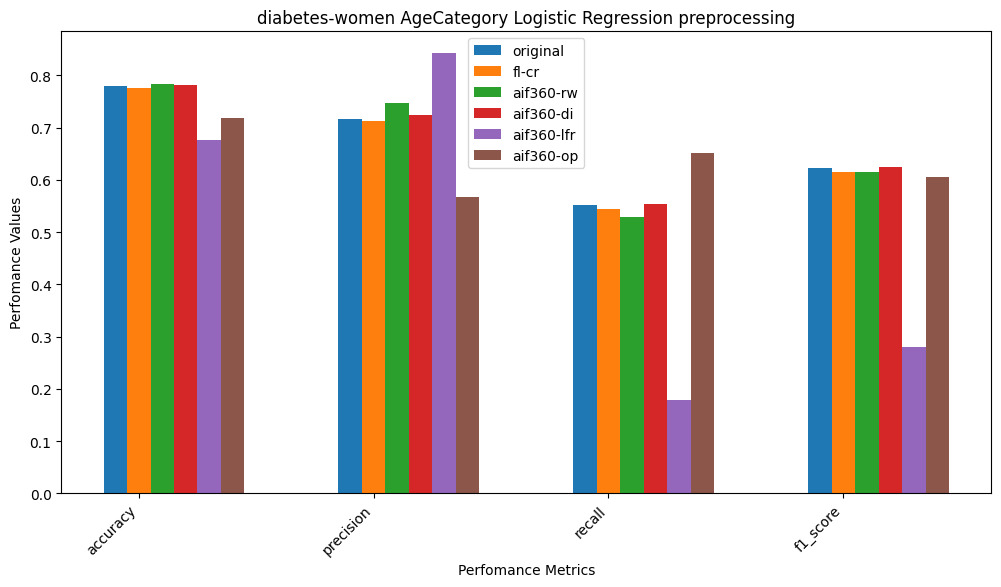

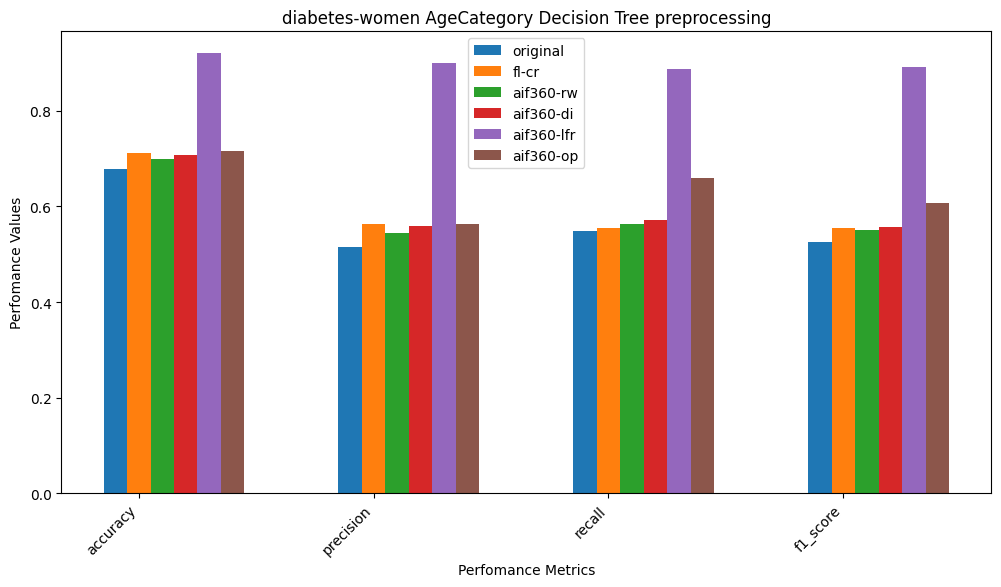

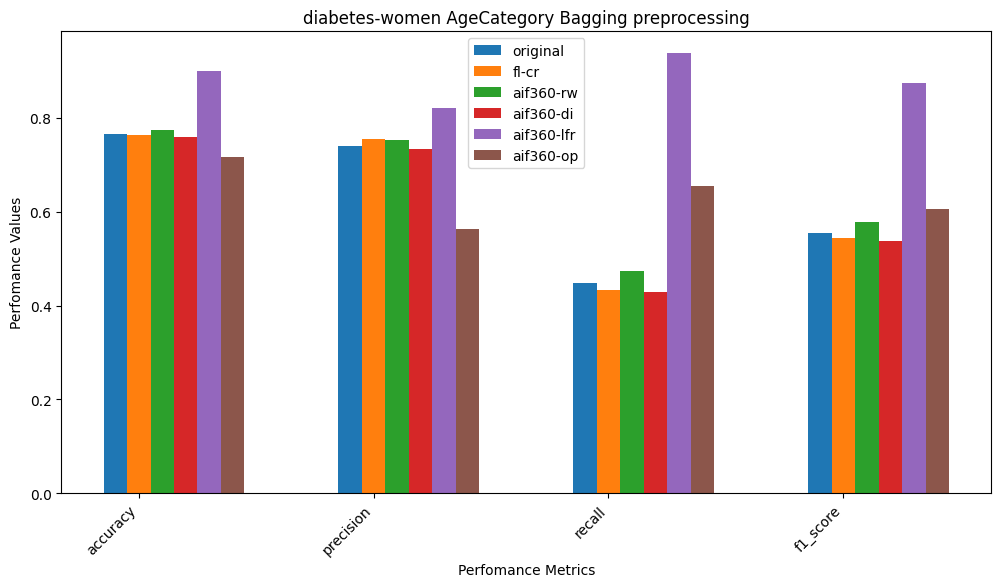

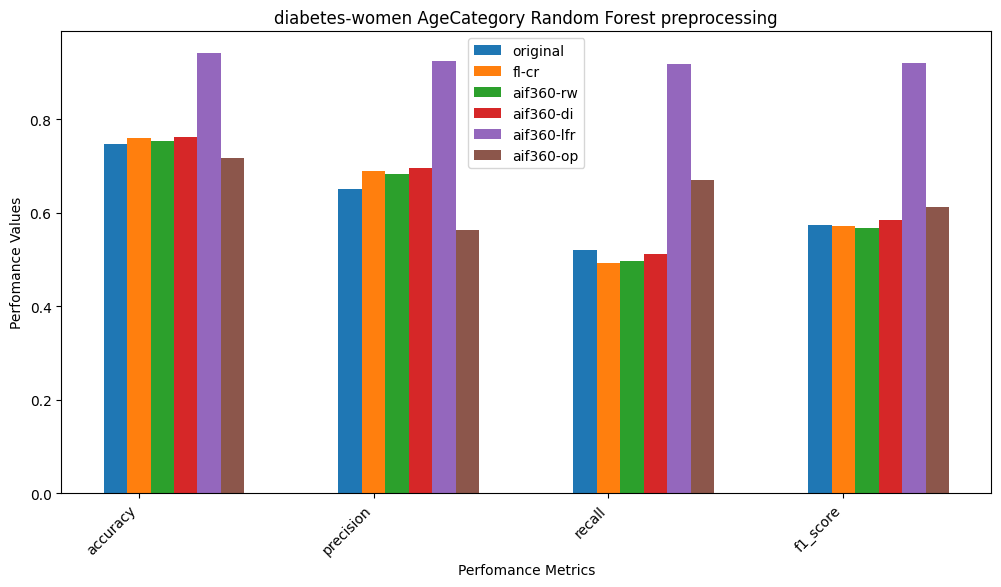

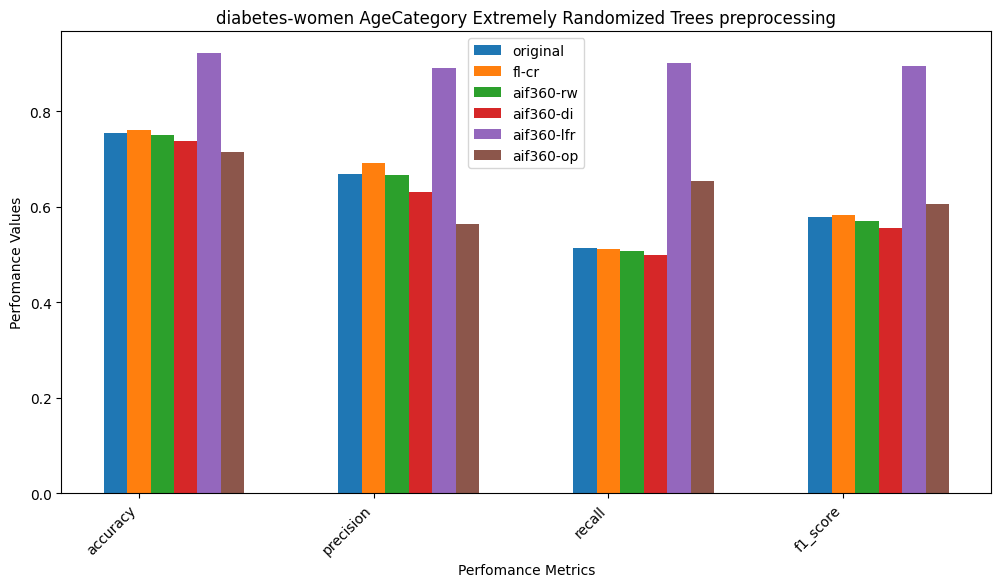

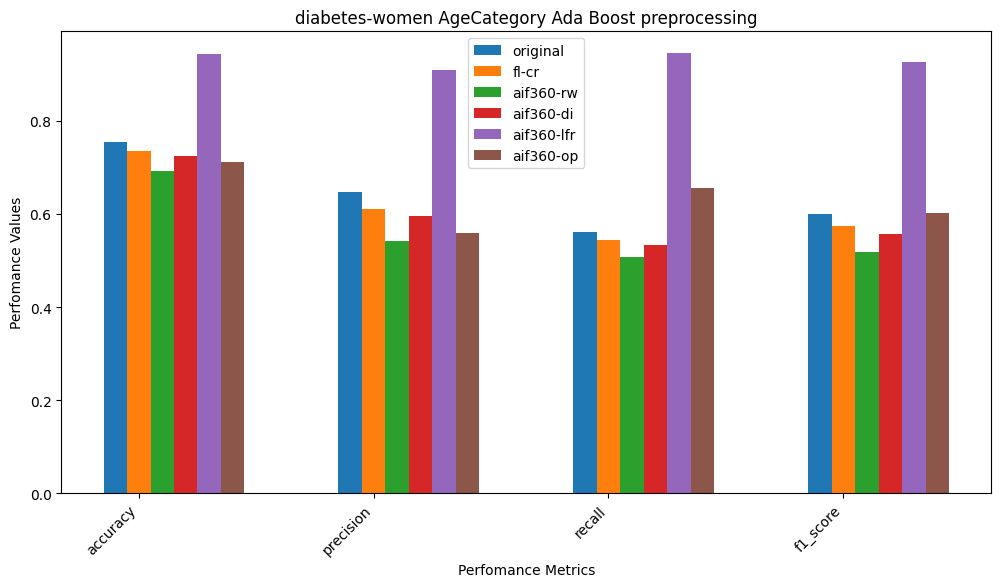

In [21]:
for dataset_name in dataset_list:
  for sensible_attribute in datasets_config[dataset_name]['sensible_attributes']:
    for m in models:
      perf_grouped_bar(performance_metrics[dataset_name][sensible_attribute], preprocessing_mitigation_list, m, 'preprocessing', dataset_name, sensible_attribute)

In [22]:
perf_data_framing(performance_metrics, 'diabetes-women', 'AgeCategory', "Logistic Regression", preprocessing_mitigation_list)

,accuracy,precision,recall,f1_score
Mitigation,,,,
original,0.779+/-0.040,0.716+/-0.043,0.553+/-0.044,0.622+/-0.033
fl-cr,0.776+/-0.041,0.713+/-0.043,0.544+/-0.048,0.616+/-0.035
aif360-rw,0.784+/-0.035,0.747+/-0.040,0.528+/-0.063,0.616+/-0.034
aif360-di,0.782+/-0.040,0.724+/-0.042,0.553+/-0.054,0.625+/-0.039
aif360-lfr,0.676+/-0.030,0.842+/-0.086,0.179+/-0.093,0.280+/-0.123
aif360-op,0.719+/-0.041,0.568+/-0.043,0.651+/-0.086,0.606+/-0.061


In [23]:
perf_data_framing(performance_metrics, 'diabetes-women', 'AgeCategory', "Bagging", preprocessing_mitigation_list)

,accuracy,precision,recall,f1_score
Mitigation,,,,
original,0.764+/-0.039,0.741+/-0.037,0.447+/-0.057,0.554+/-0.037
fl-cr,0.763+/-0.044,0.754+/-0.067,0.432+/-0.077,0.543+/-0.053
aif360-rw,0.775+/-0.031,0.752+/-0.067,0.474+/-0.052,0.579+/-0.042
aif360-di,0.760+/-0.033,0.732+/-0.050,0.428+/-0.062,0.537+/-0.051
aif360-lfr,0.899+/-0.008,0.820+/-0.017,0.937+/-0.013,0.874+/-0.011
aif360-op,0.716+/-0.036,0.563+/-0.041,0.655+/-0.084,0.605+/-0.059


### all pre-processing techniques, division, all ML models

k= 5

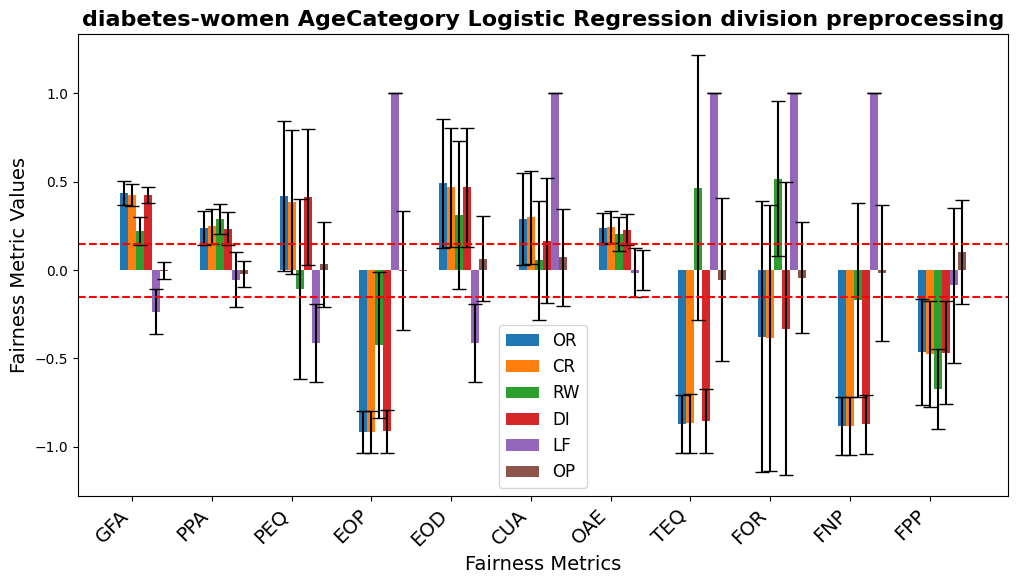

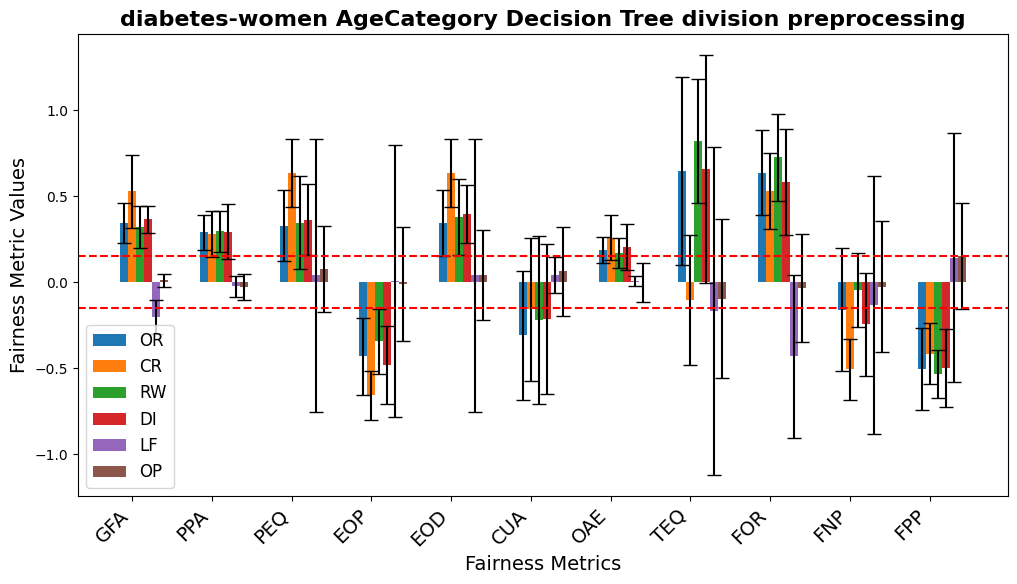

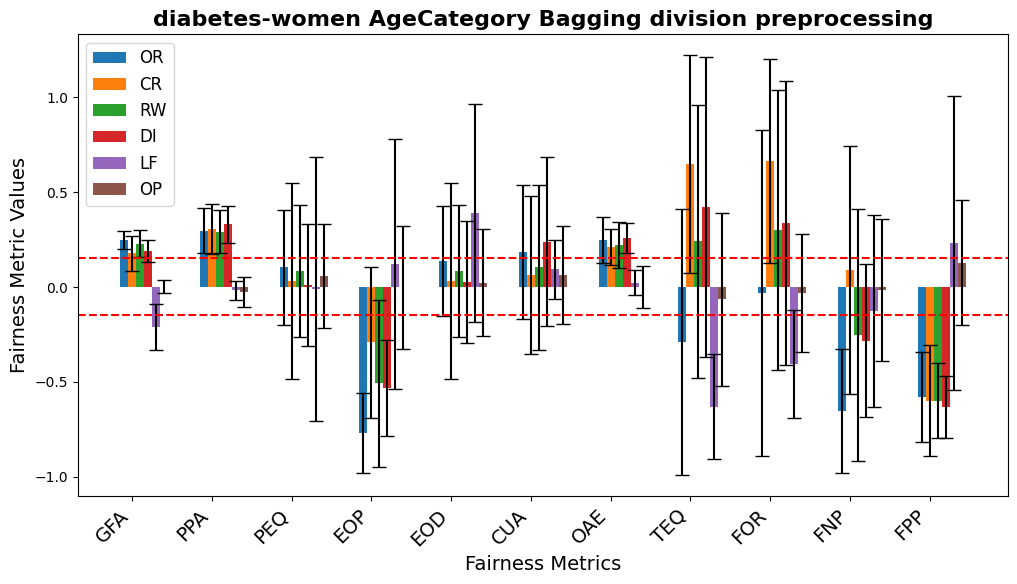

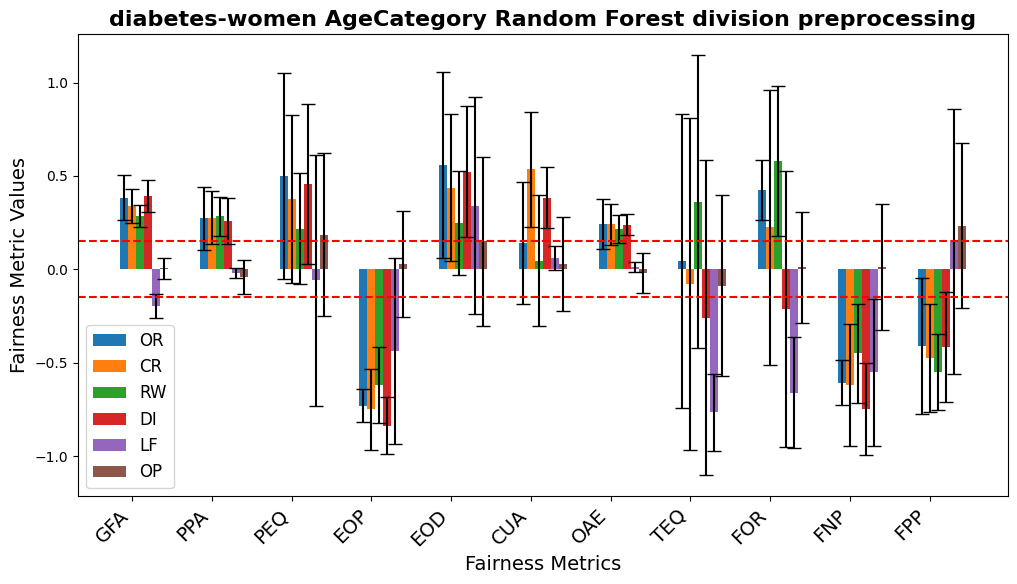

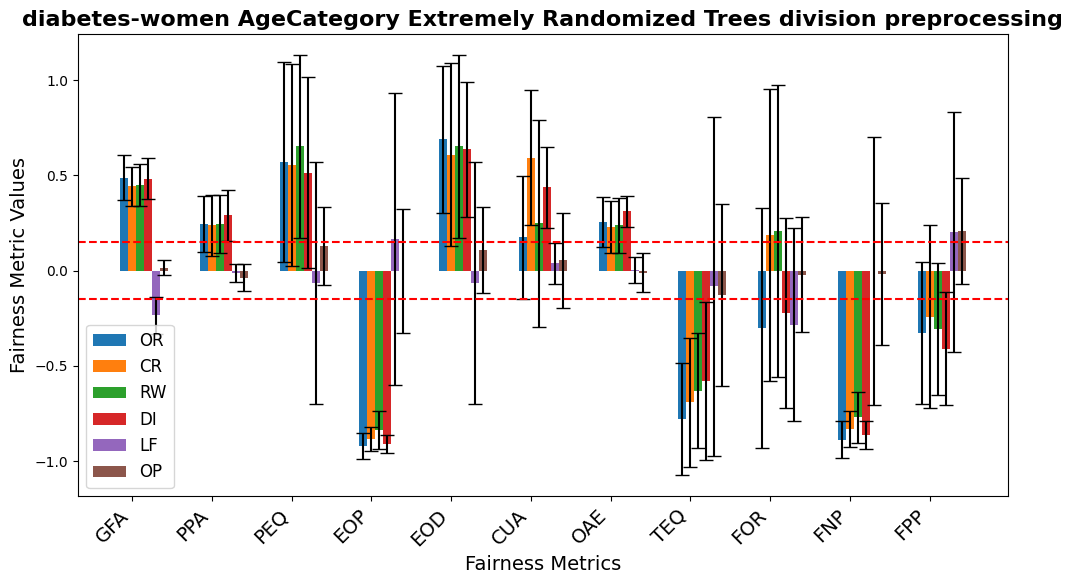

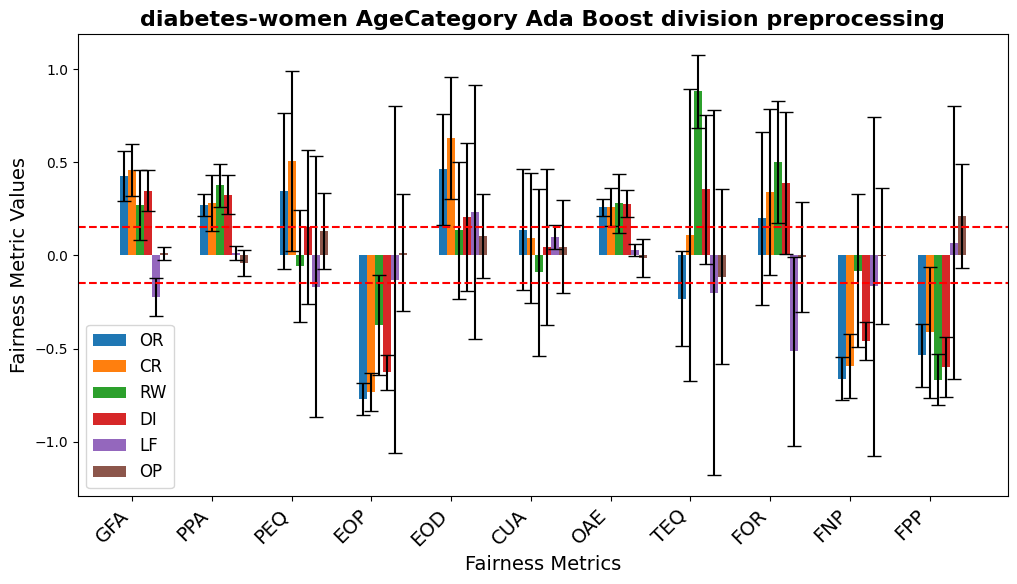

In [24]:
for dataset_name in dataset_list:
  for sensible_attribute in datasets_config[dataset_name]['sensible_attributes']:
    for m in models:
      grouped_bar_std_dev(preprocessing_metrics[dataset_name][sensible_attribute], preprocessing_mitigation_list, "division", m, 'preprocessing', dataset_name, sensible_attribute)

K = 10

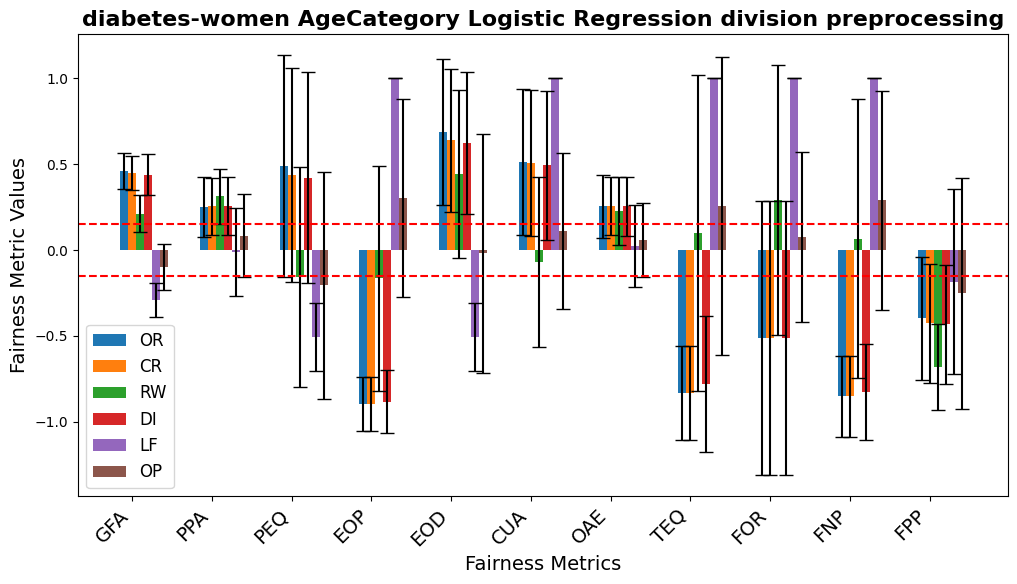

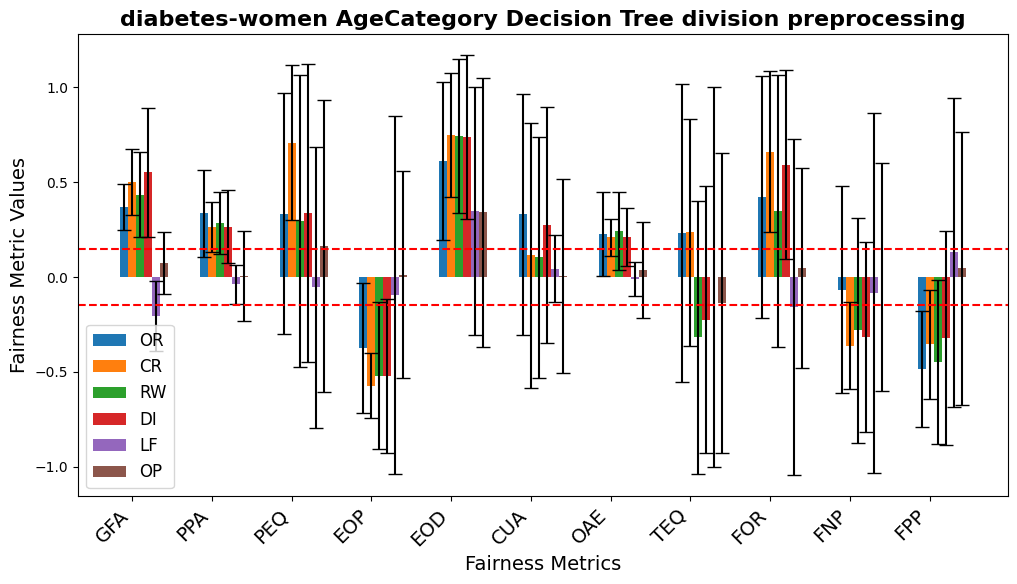

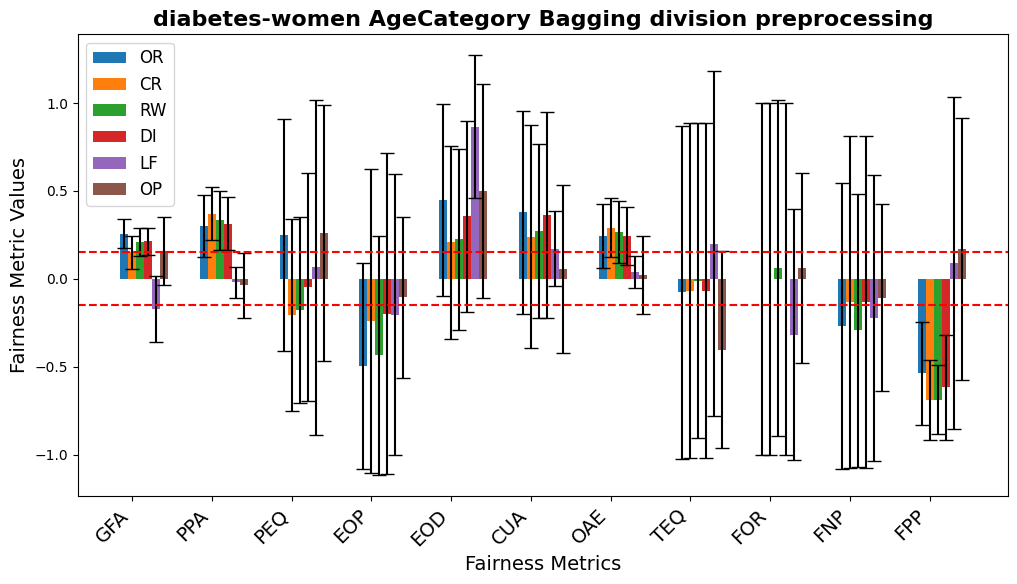

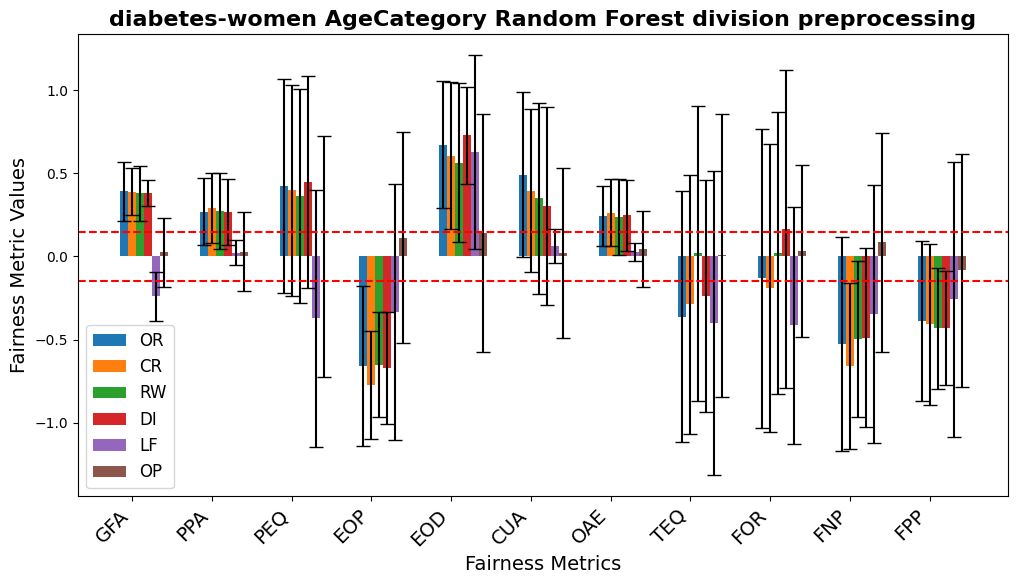

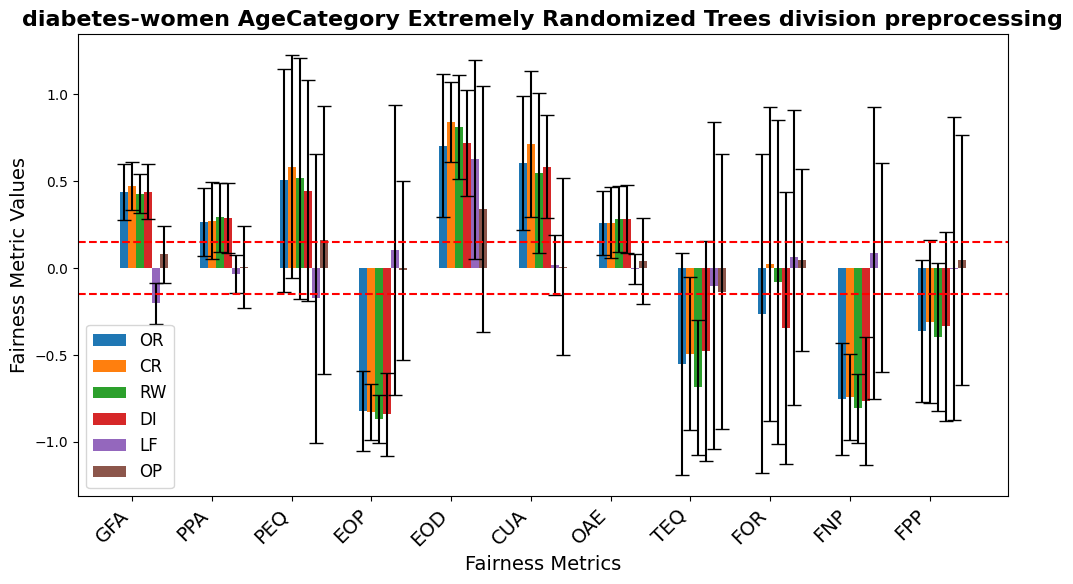

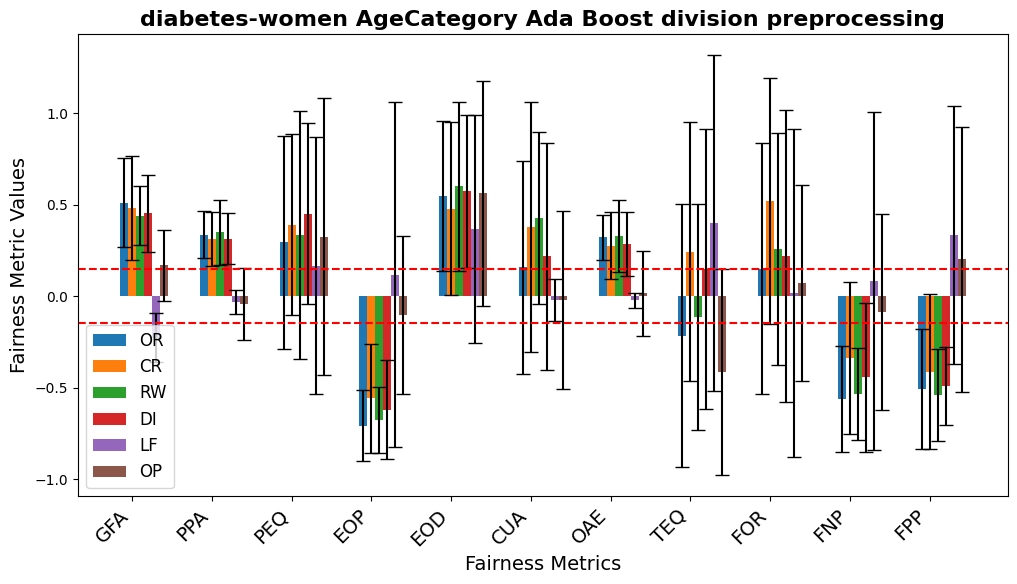

In [ ]:
for dataset_name in dataset_list:
  for sensible_attribute in datasets_config[dataset_name]['sensible_attributes']:
    for m in models:
      grouped_bar_std_dev(preprocessing_metrics[dataset_name][sensible_attribute], preprocessing_mitigation_list, "division", m, 'preprocessing', dataset_name, sensible_attribute)

K=5

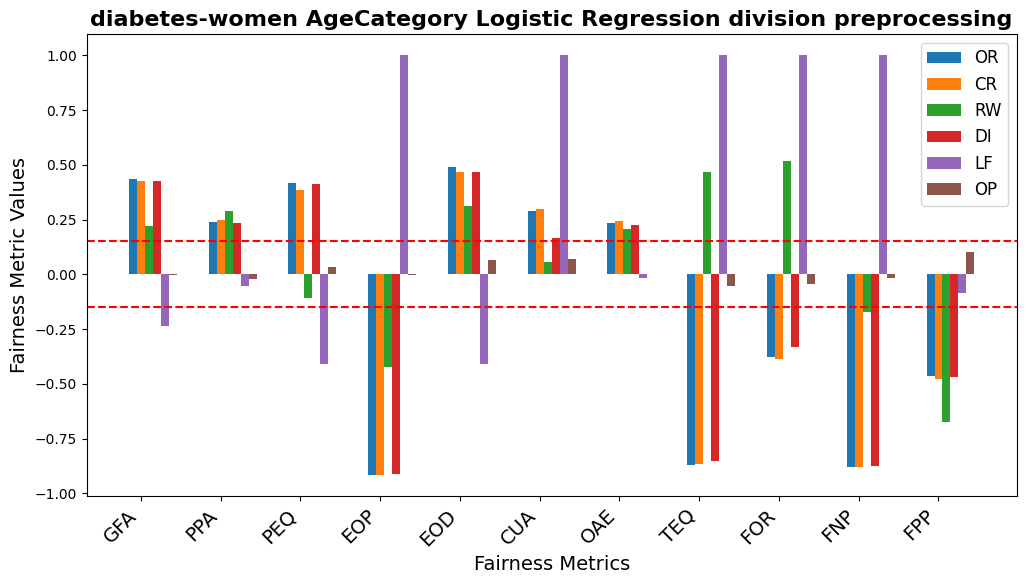

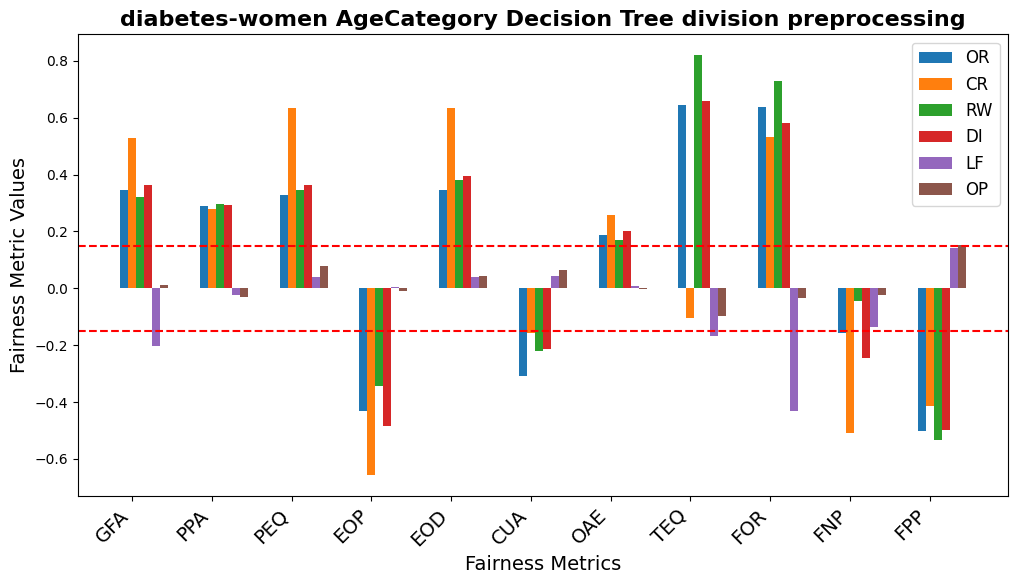

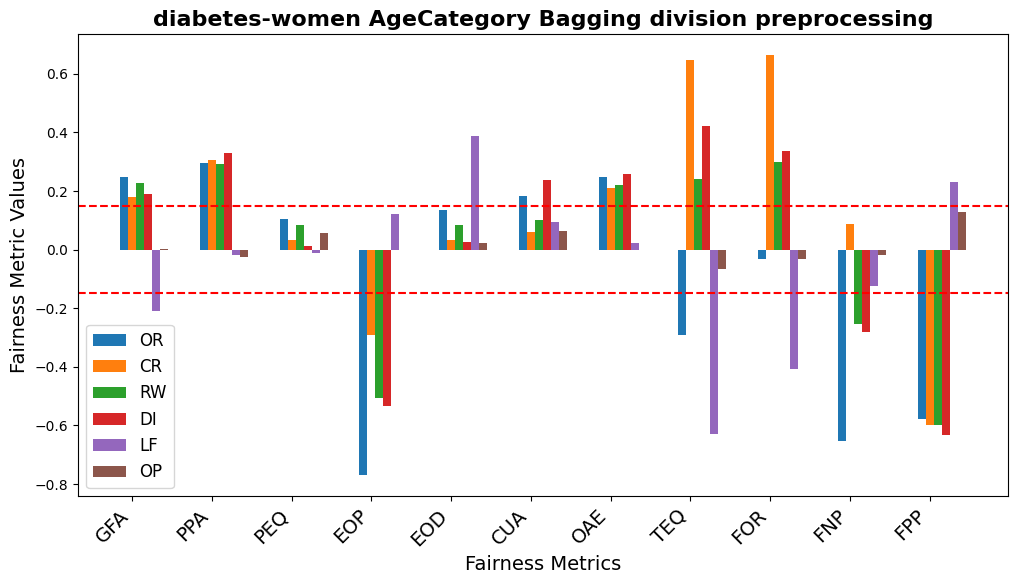

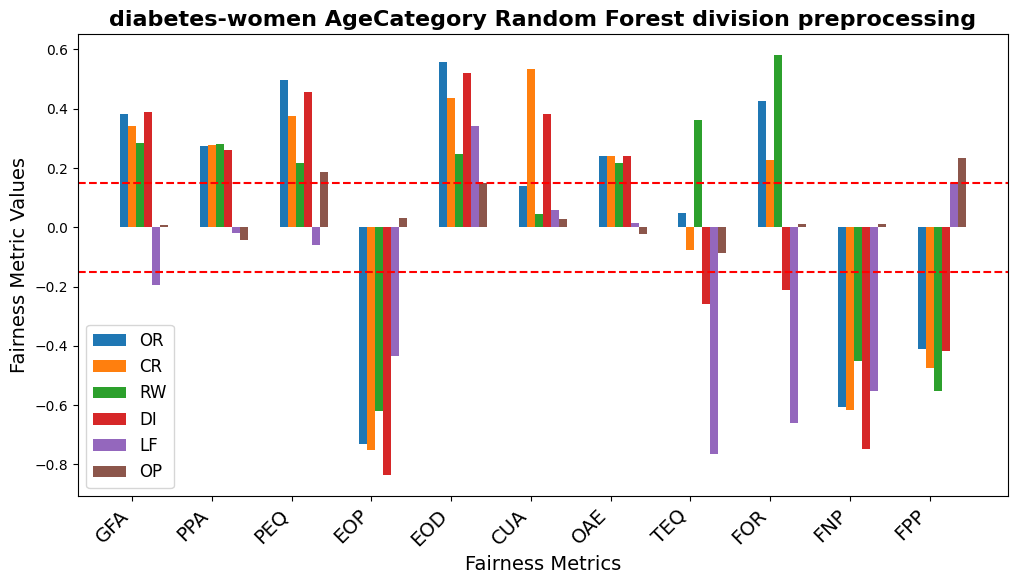

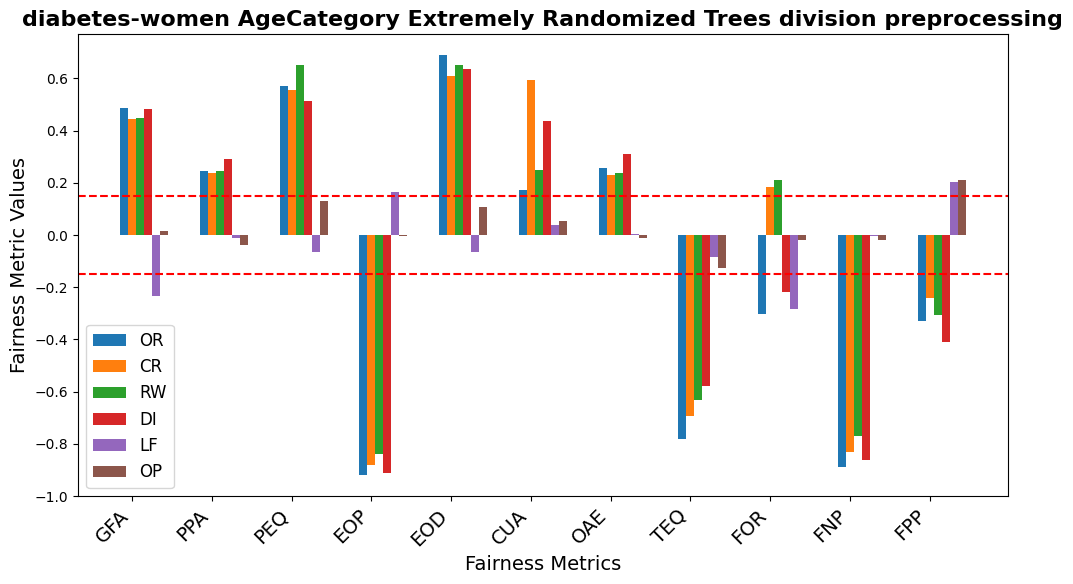

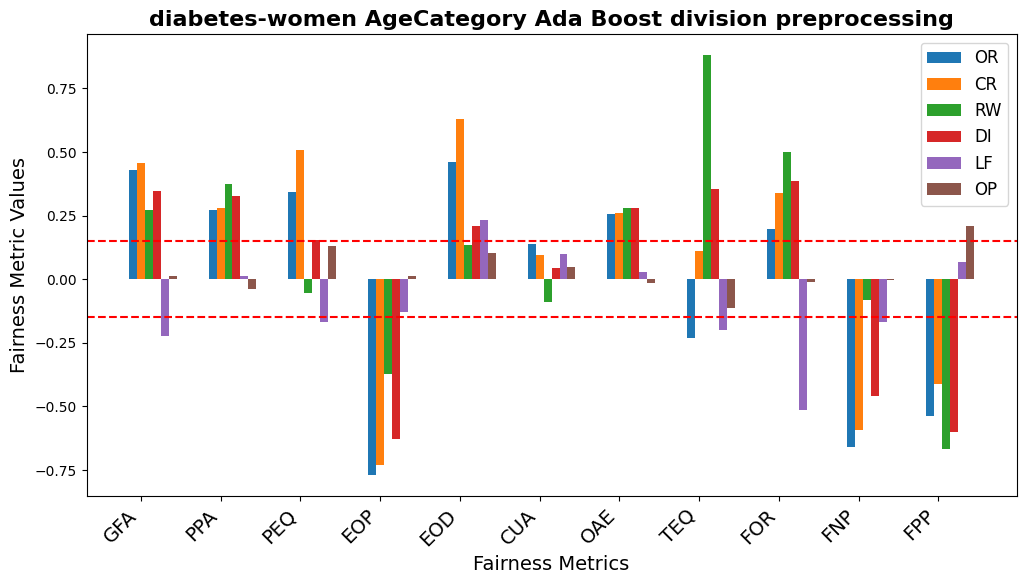

In [25]:
for dataset_name in dataset_list:
  for sensible_attribute in datasets_config[dataset_name]['sensible_attributes']:
    for m in models:
      grouped_bar(preprocessing_metrics[dataset_name][sensible_attribute], preprocessing_mitigation_list, "division", m, 'preprocessing', dataset_name, sensible_attribute)

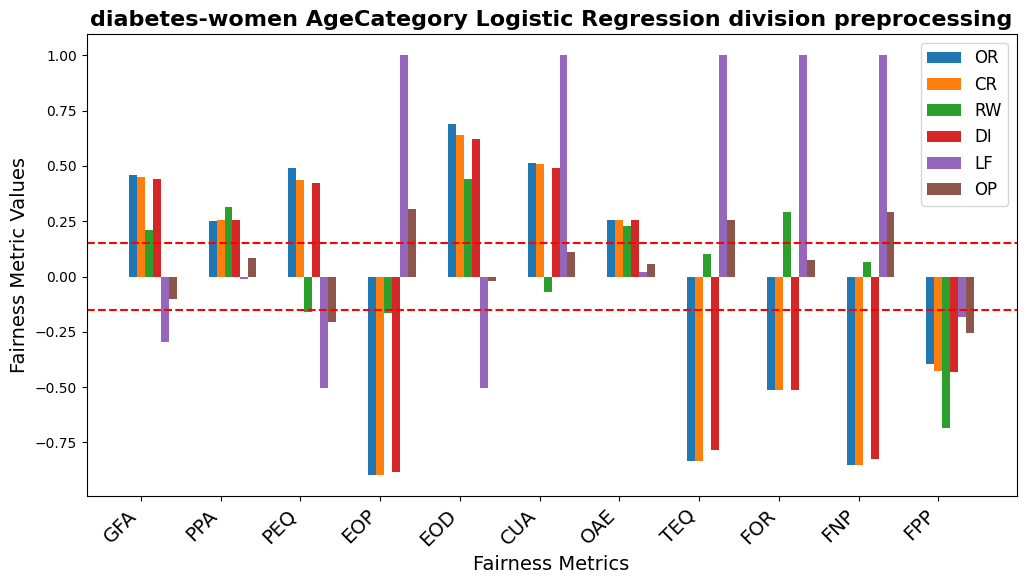

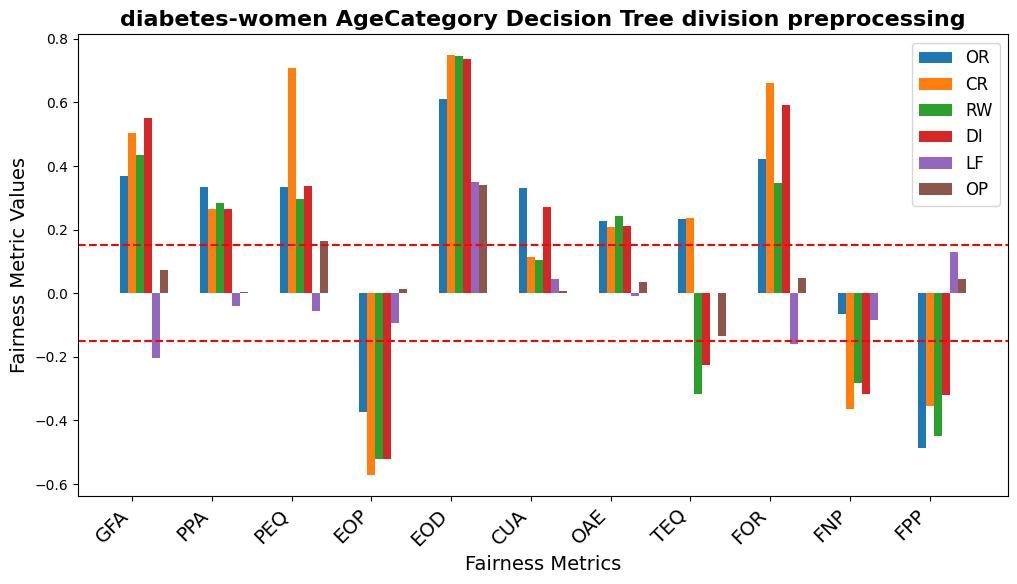

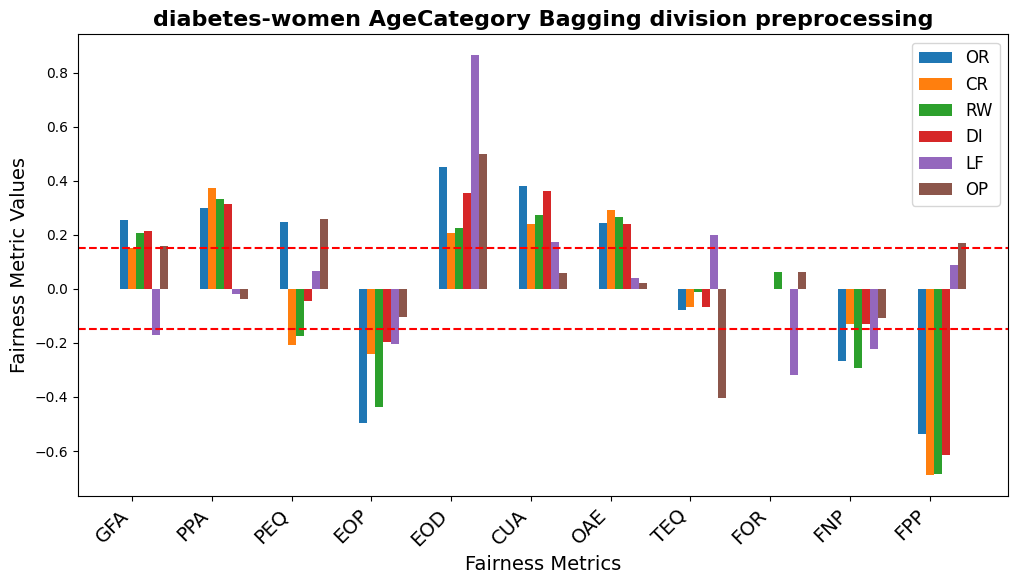

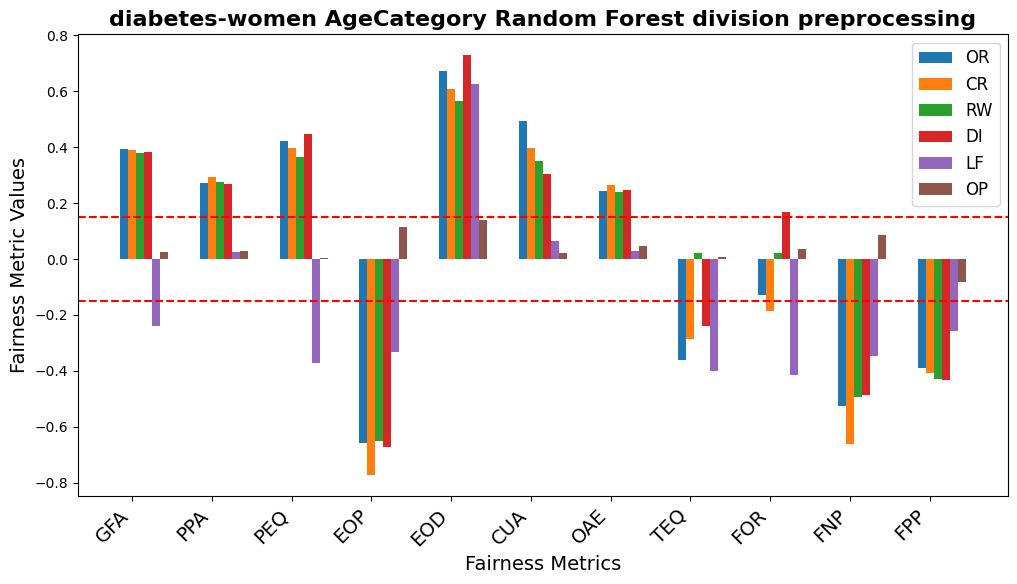

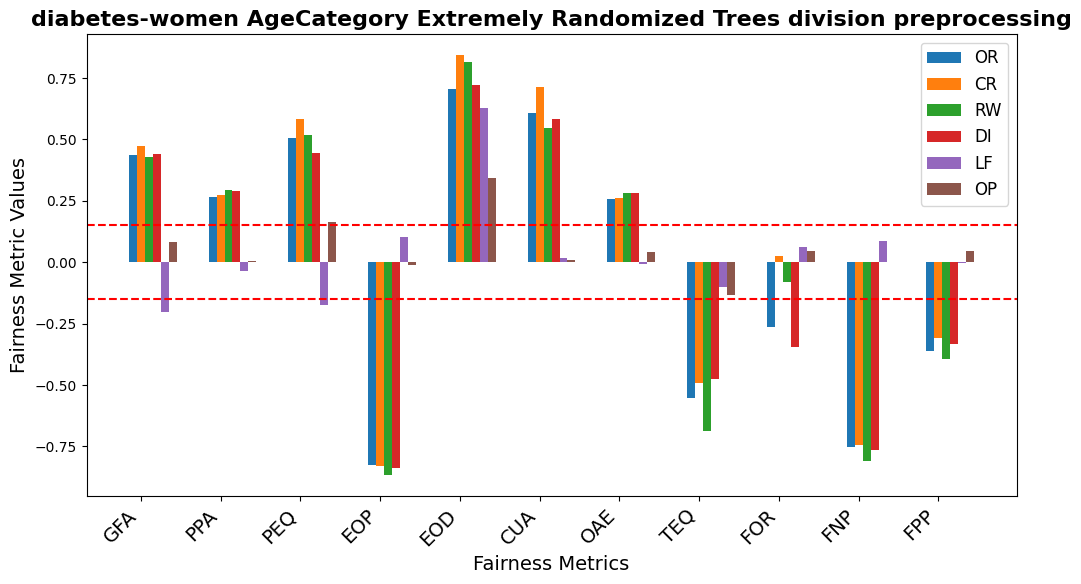

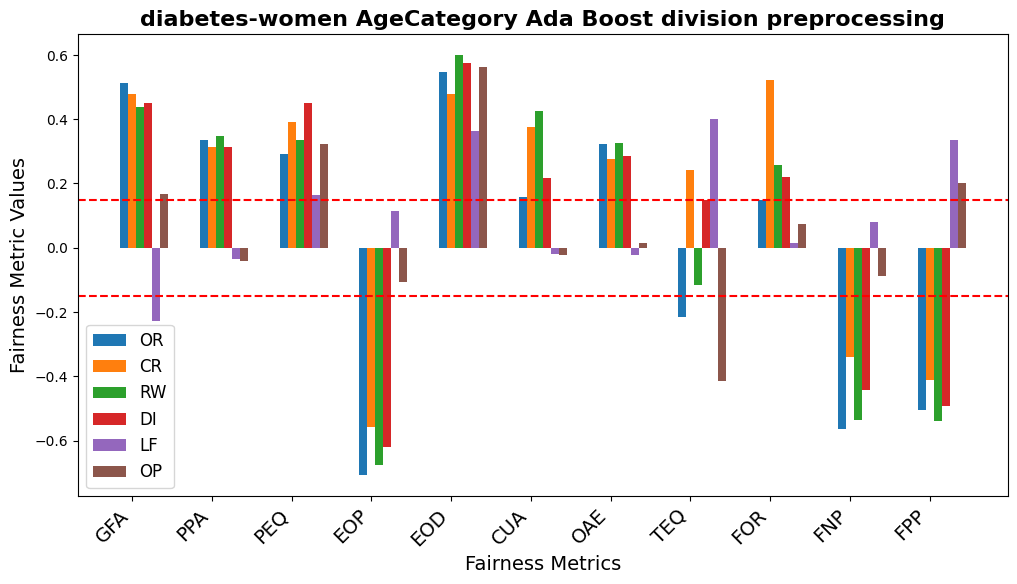

In [ ]:
for dataset_name in dataset_list:
  for sensible_attribute in datasets_config[dataset_name]['sensible_attributes']:
    for m in models:
      grouped_bar(preprocessing_metrics[dataset_name][sensible_attribute], preprocessing_mitigation_list, "division", m, 'preprocessing', dataset_name, sensible_attribute)

serve che tutte le metriche siano comprese tra due estremi. inoltre sarebbe bello averle centrate sullo zero, per poter fare dei radar plot relativi a ciascuna configurazione e calcolare come valore finale l'area del radar (se è possibile).

altra cosa invece carina è di prendere tutte le metriche insieme e trasformarle in un vettore: con dimenzionality reduction si può mostrare tutti gli algoritmi su un unico grafico, però bisogna stare attenti a cosa mostriamo se facciamo riduzione dei vettori a due sole dimenzioni (es. cosa significa se ci troviamo nel quadrante in alto a destra o in quello in basso a sinistra?). però una cosa interessante è vedere come i diversi algoritmi sono in relazioni tra di loro, quindi una valutazione più qualitativa che quantitativa...

altra idea: se calcolassimo una componente su un asse o su una direzione? però chissà cosa scegliere...

Transform dictionary into a dataframe.

In [ ]:
#data_framing(overall_metrics, 'diabetes-women', 'AgeCategory', "division", "Logistic Regression", preprocessing_mitigation_list)

### all pre-processing techniques, subtraction, all ML models

k=5

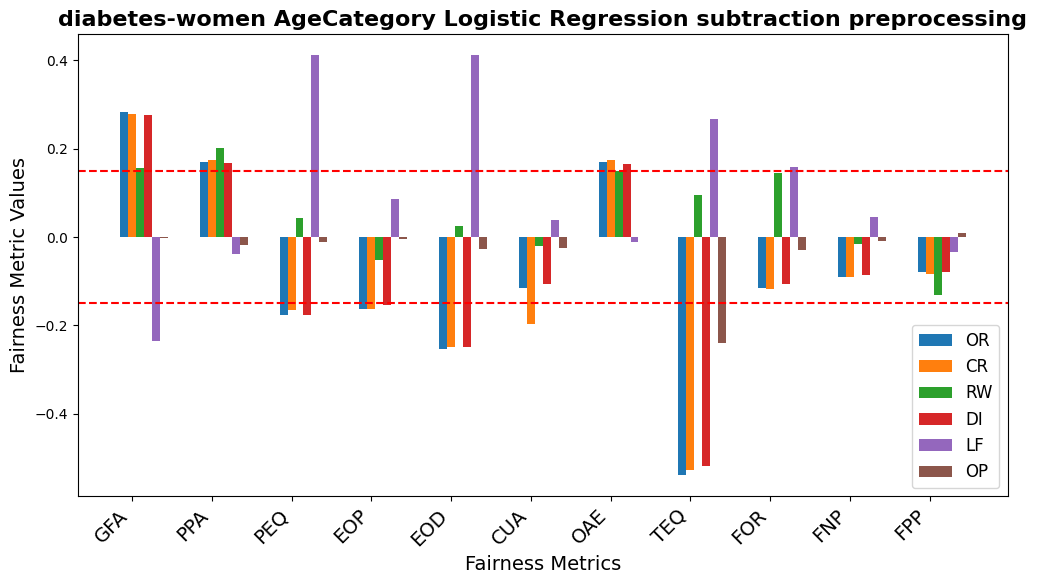

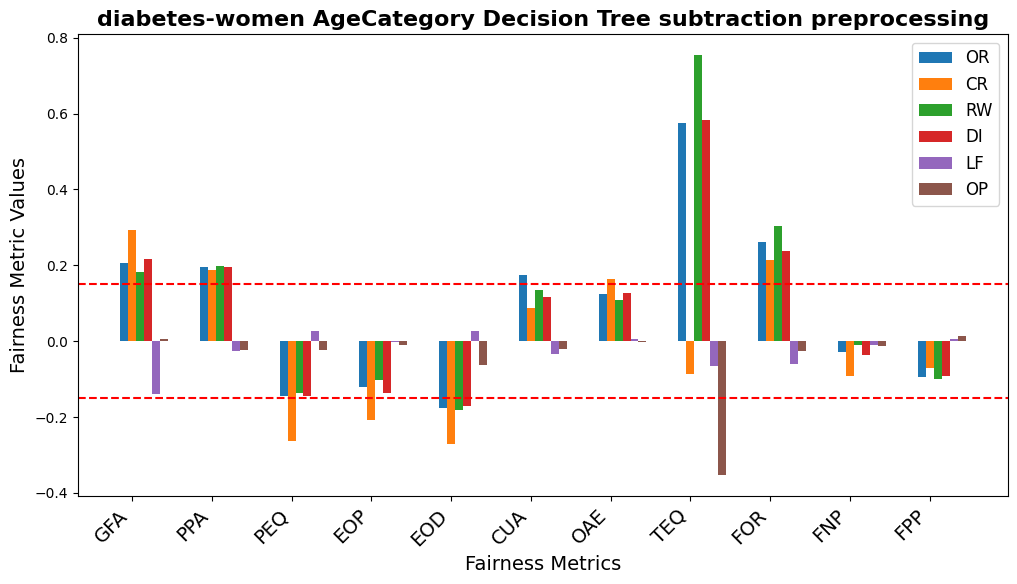

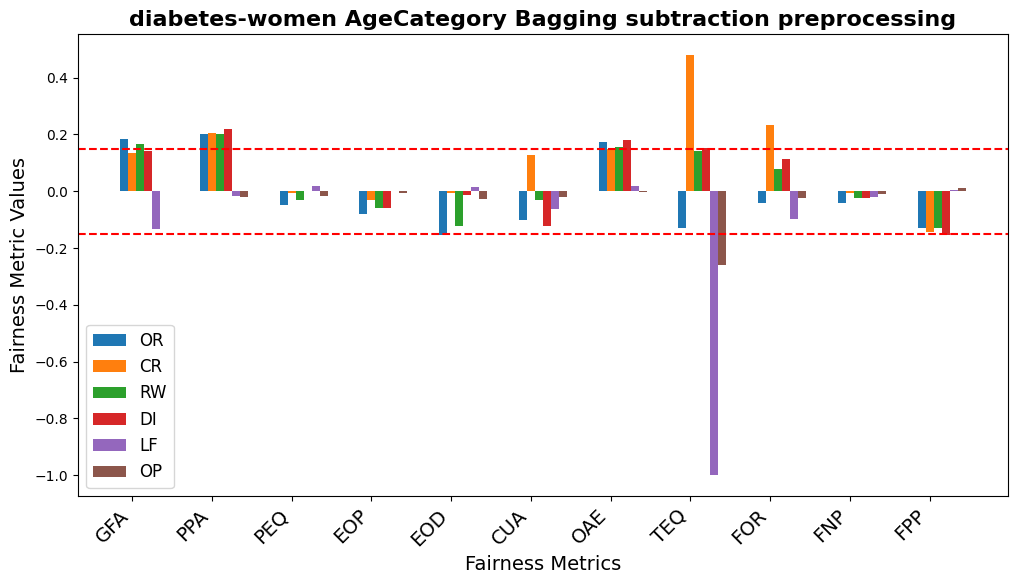

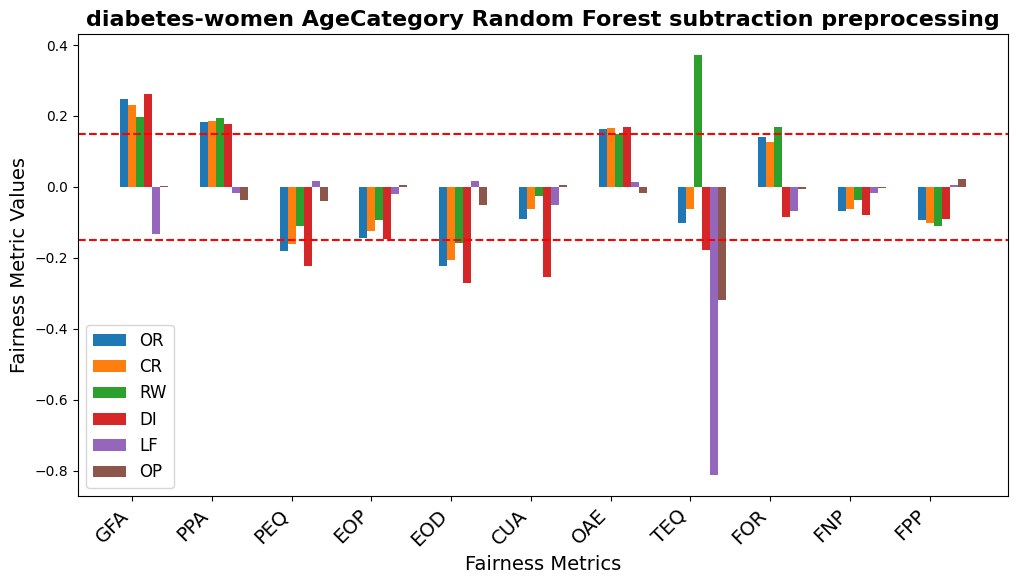

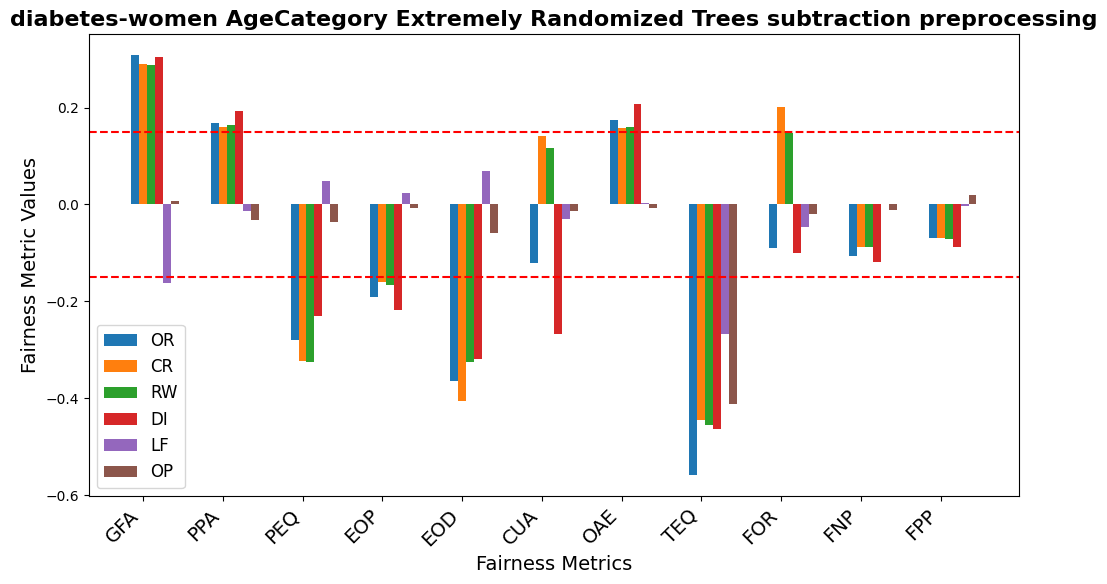

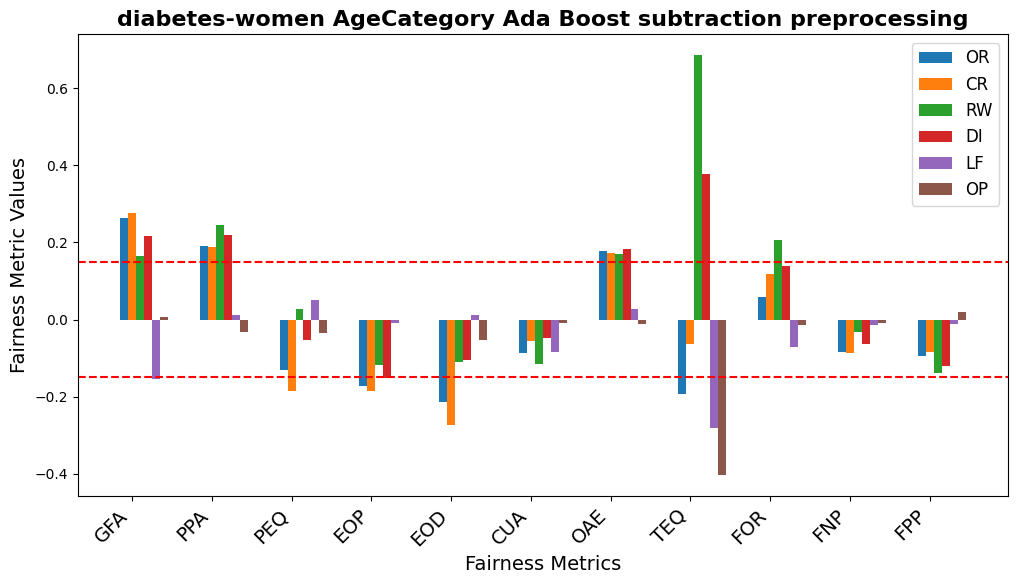

In [27]:
for dataset_name in dataset_list:
  for sensible_attribute in datasets_config[dataset_name]['sensible_attributes']:
    for m in models:
      grouped_bar(preprocessing_metrics[dataset_name][sensible_attribute], preprocessing_mitigation_list, "subtraction", m, 'preprocessing', dataset_name, sensible_attribute)

k=10

In [ ]:
for dataset_name in dataset_list:
  for sensible_attribute in datasets_config[dataset_name]['sensible_attributes']:
    for m in models:
      grouped_bar(preprocessing_metrics[dataset_name][sensible_attribute], preprocessing_mitigation_list, "subtraction", m, 'preprocessing', dataset_name, sensible_attribute)

# In-processing results

In [28]:
for m in models:
  inprocessing_mitigation_list.insert(0, 'orig-'+str(m))

### Performance

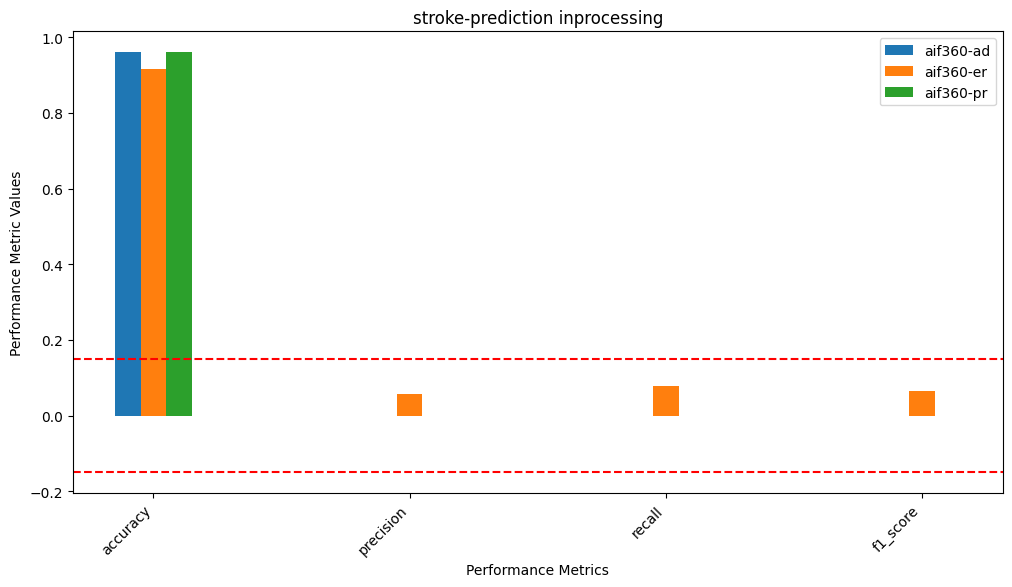

In [ ]:
for dataset_name in dataset_list:
  for sensible_attribute in datasets_config[dataset_name]['sensible_attributes']:
    perf_grouped_bar_no_model(performance_metrics[dataset_name][sensible_attribute], ["aif360-ad", "aif360-er",'aif360-pr'], 'inprocessing')

In [ ]:
#perf_data_framing(performance_metrics, 'diabetes-women', 'AgeCategory', None, ["aif360-ad", "aif360-er",'aif360-pr'])

### all in-processing techniques, division, no ML models

k=5

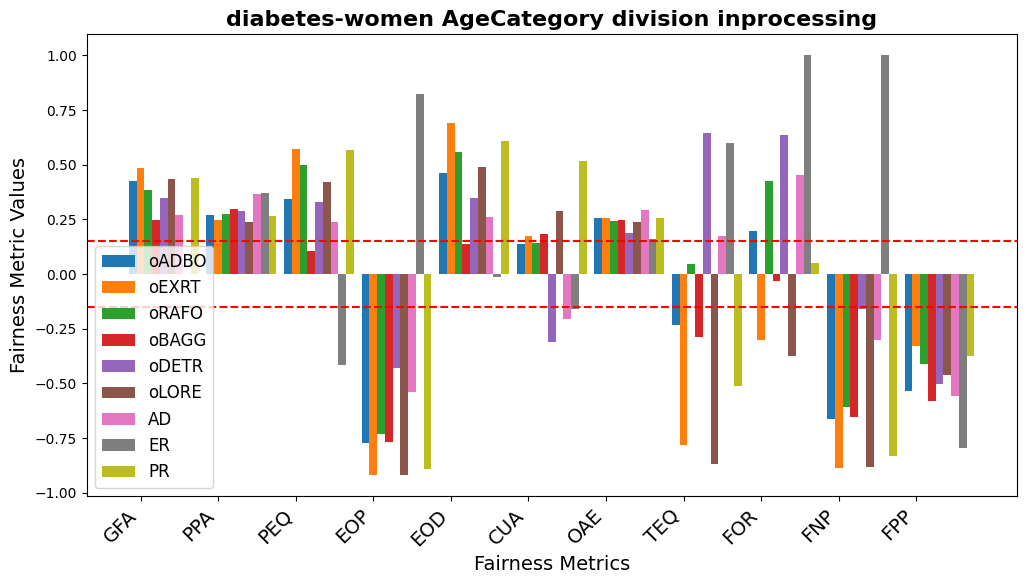

In [29]:
for dataset_name in dataset_list:
  for sensible_attribute in datasets_config[dataset_name]['sensible_attributes']:
    grouped_bar_no_model(inprocessing_metrics[dataset_name][sensible_attribute], inprocessing_mitigation_list, "division", 'inprocessing', dataset_name, sensible_attribute)

k=10

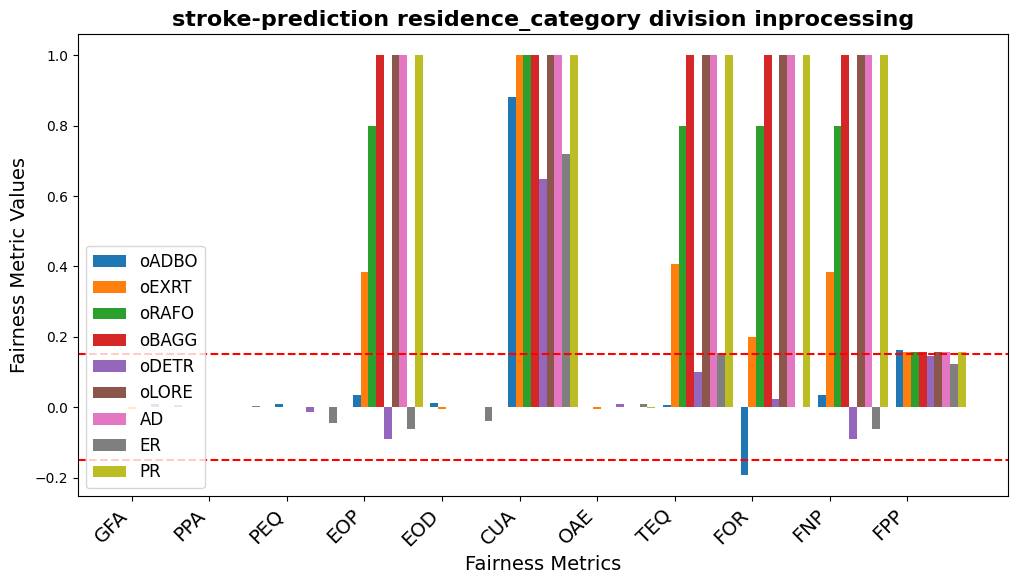

In [ ]:
for dataset_name in dataset_list:
  for sensible_attribute in datasets_config[dataset_name]['sensible_attributes']:
    grouped_bar_no_model(inprocessing_metrics[dataset_name][sensible_attribute], inprocessing_mitigation_list, "division", 'inprocessing', dataset_name, sensible_attribute)

### all three in-processing techniques, subtraction, no ML models

k=5

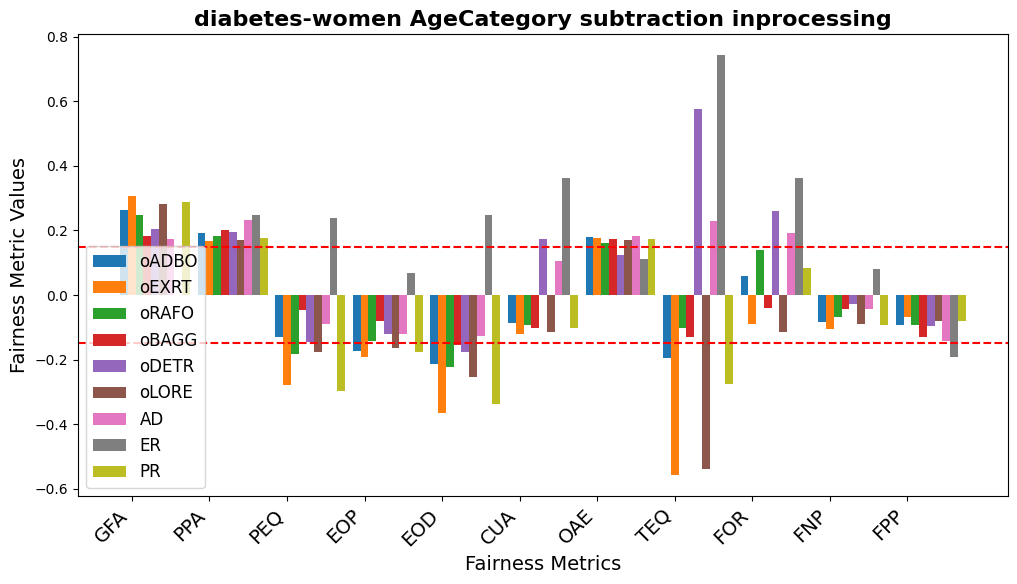

In [30]:
for dataset_name in dataset_list:
  for sensible_attribute in datasets_config[dataset_name]['sensible_attributes']:
    grouped_bar_no_model(inprocessing_metrics[dataset_name][sensible_attribute], inprocessing_mitigation_list, "subtraction", 'inprocessing', dataset_name, sensible_attribute)

k=10

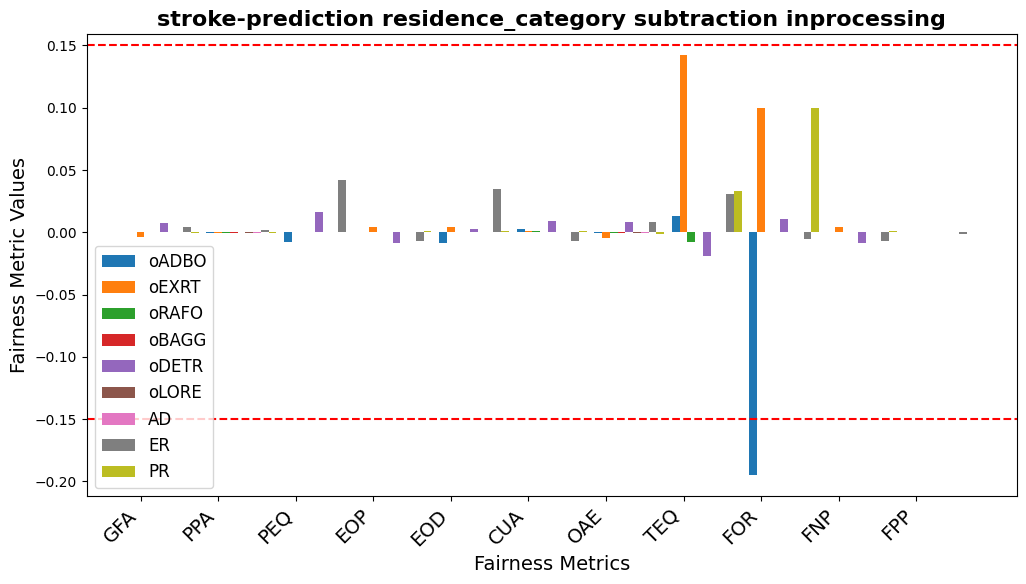

In [ ]:
for dataset_name in dataset_list:
  for sensible_attribute in datasets_config[dataset_name]['sensible_attributes']:
    grouped_bar_no_model(inprocessing_metrics[dataset_name][sensible_attribute], inprocessing_mitigation_list, "subtraction", 'inprocessing', dataset_name, sensible_attribute)

# Post-processing results

In [ ]:
postprocessing_mitigation_list.insert(0,'original')

### Performance

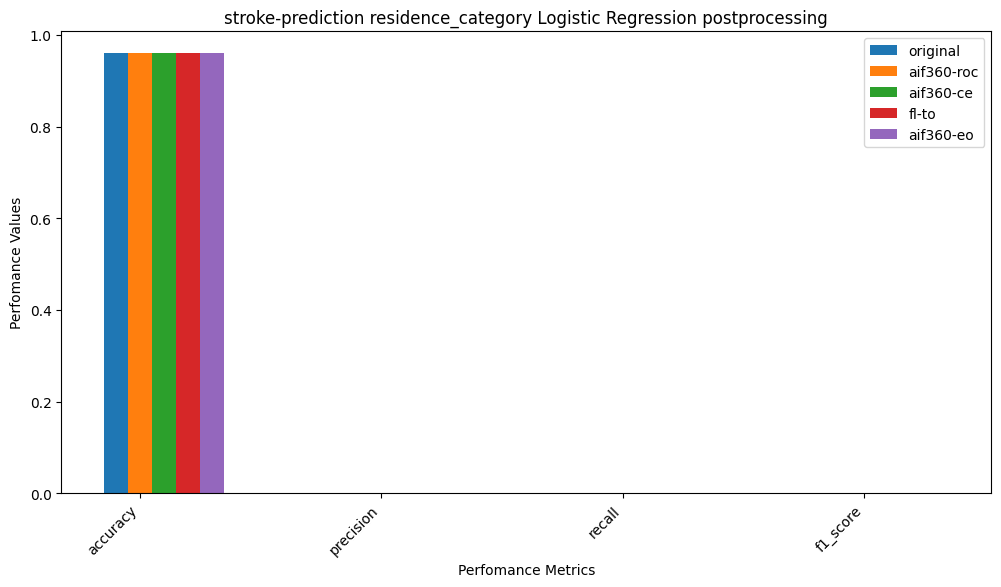

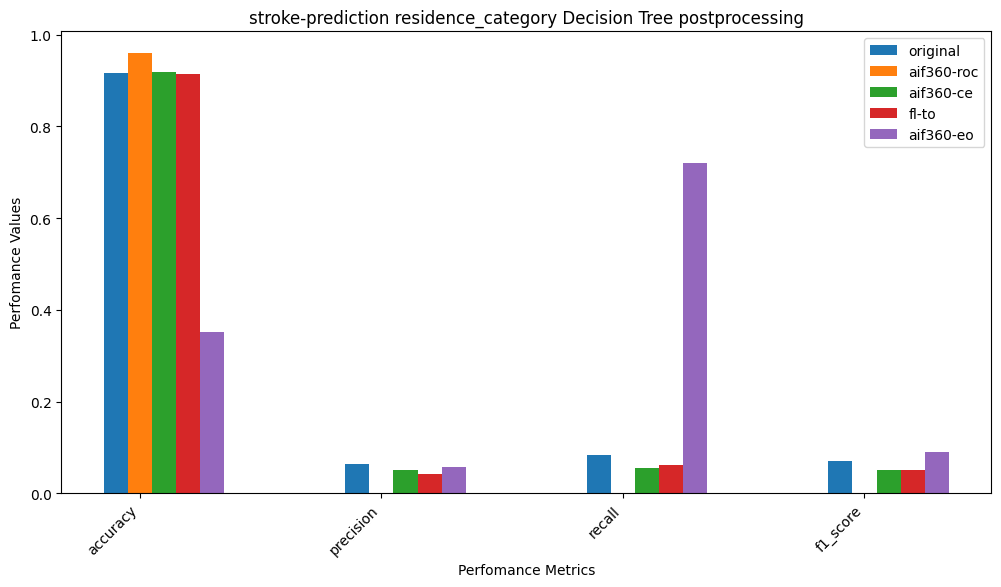

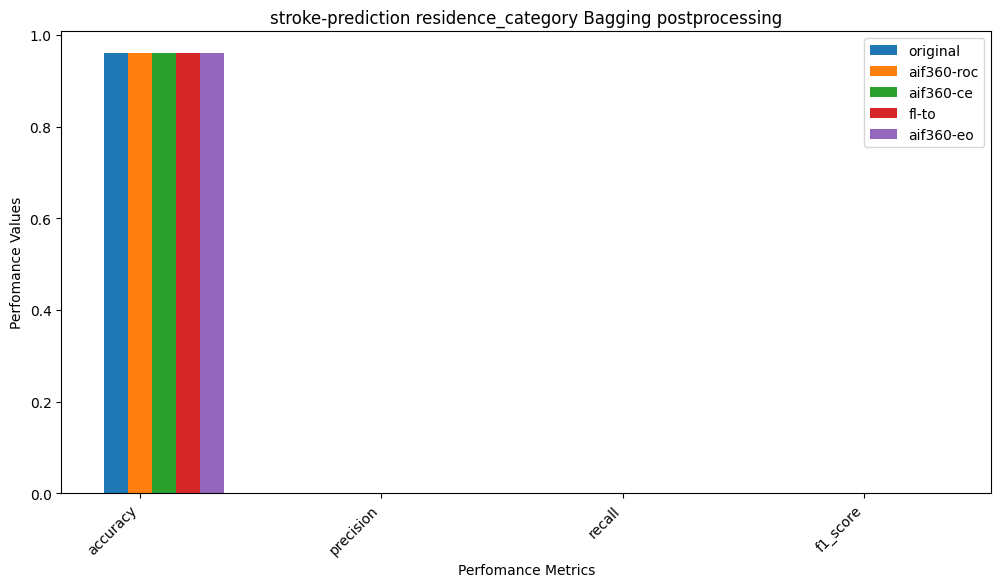

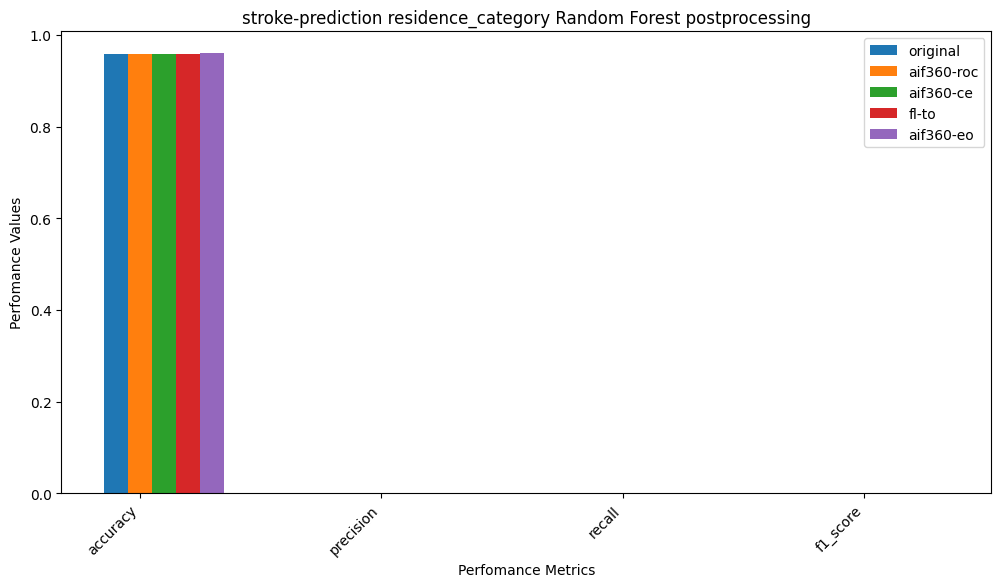

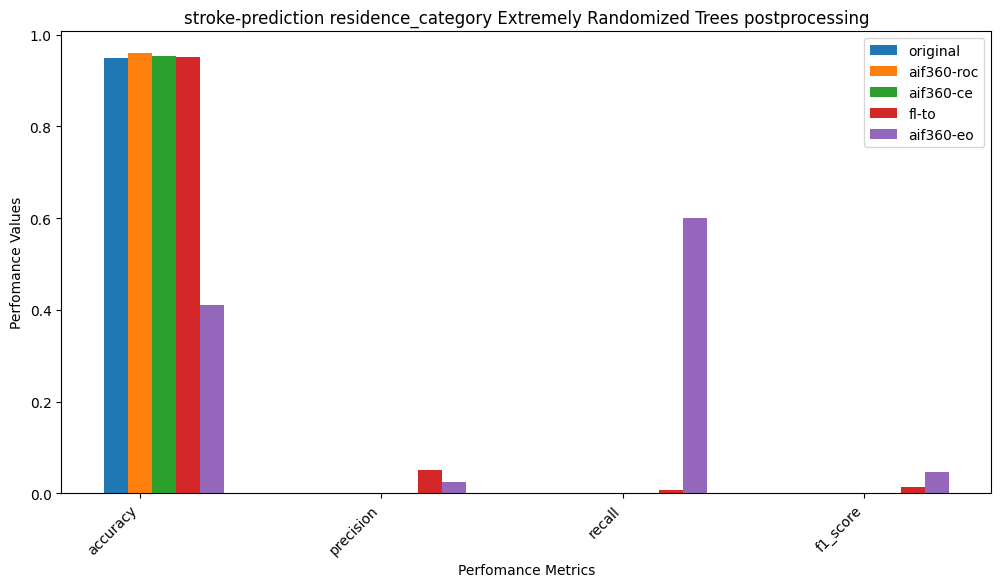

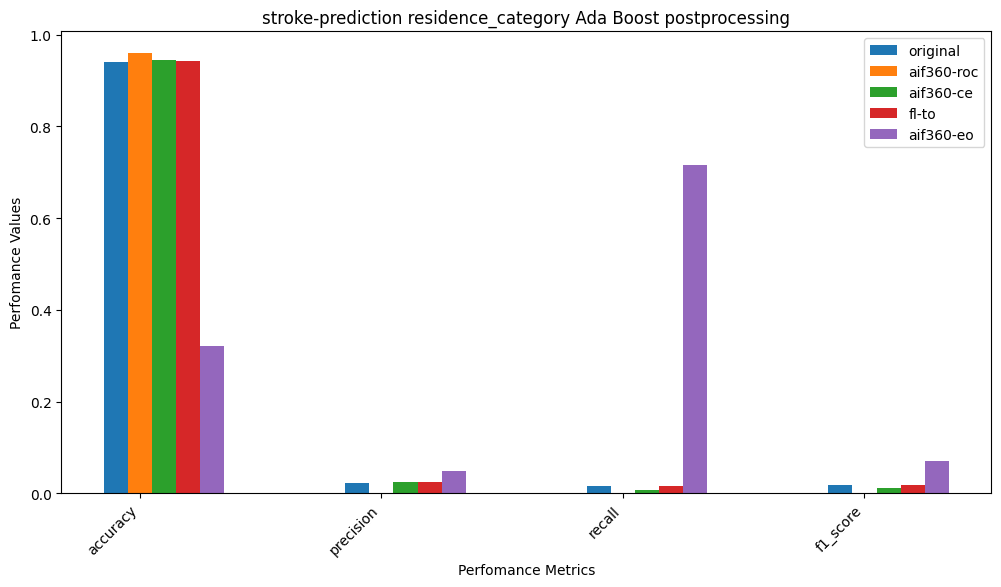

In [ ]:
for dataset_name in dataset_list:
  for sensible_attribute in datasets_config[dataset_name]['sensible_attributes']:
    for m in models:
      perf_grouped_bar(performance_metrics[dataset_name][sensible_attribute], postprocessing_mitigation_list, m, 'postprocessing', dataset_name, sensible_attribute)

In [ ]:
#perf_data_framing(performance_metrics, 'diabetes-women', 'AgeCategory', "Logistic Regression", postprocessing_mitigation_list)

In [ ]:
#perf_data_framing(performance_metrics, 'diabetes-women', 'AgeCategory', "Bagging", postprocessing_mitigation_list)

### all post-processing techniques, division, ML models

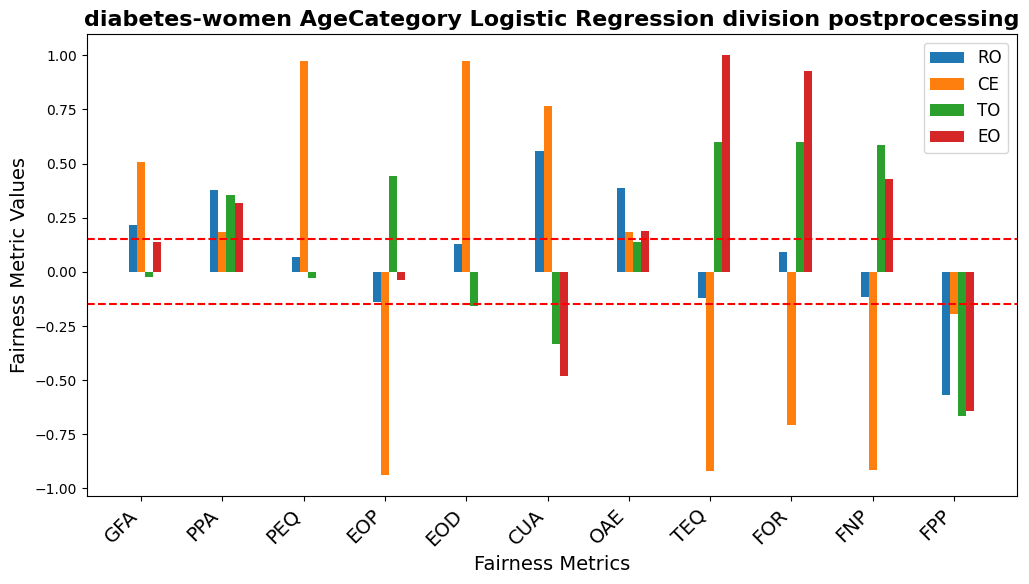

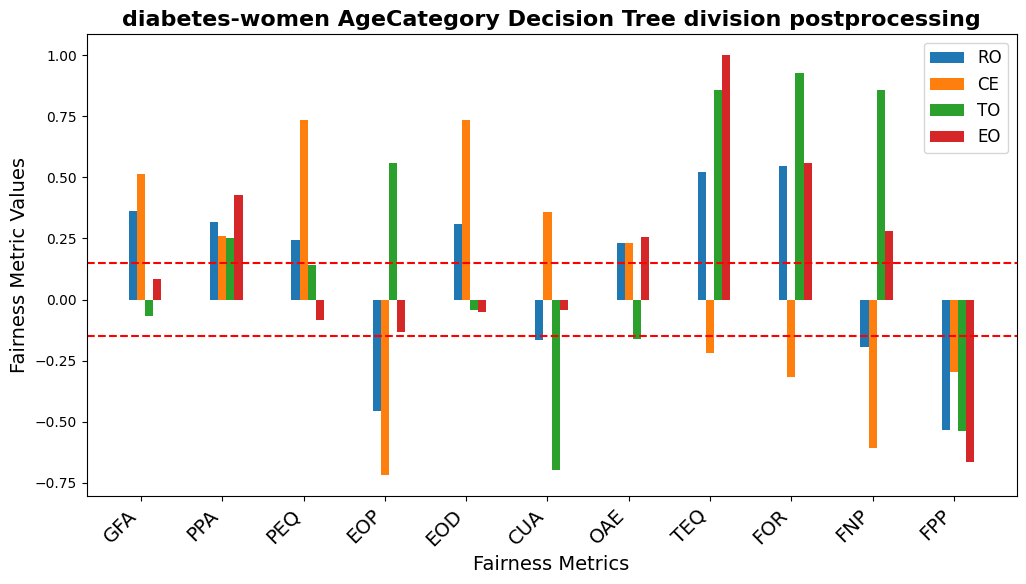

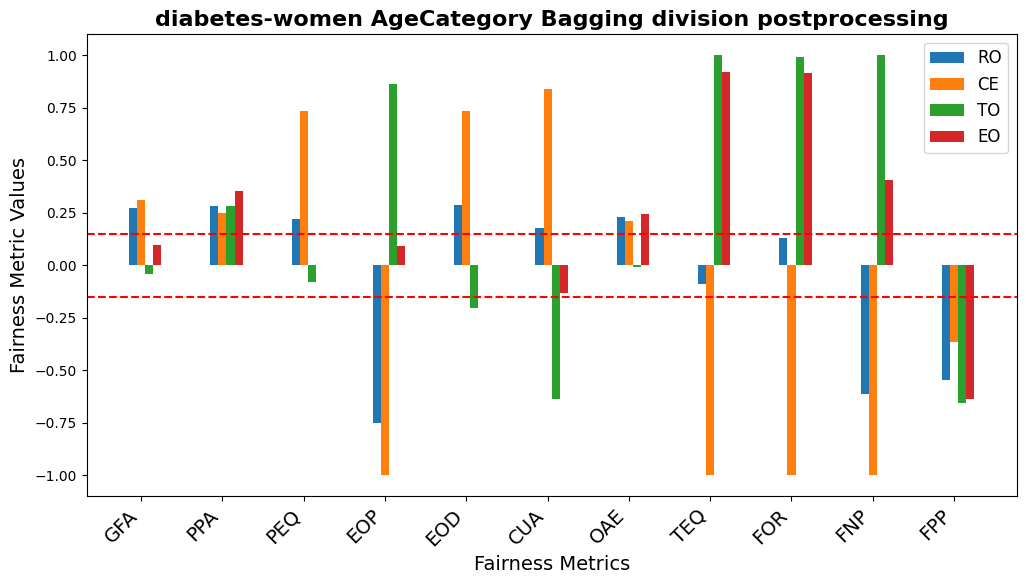

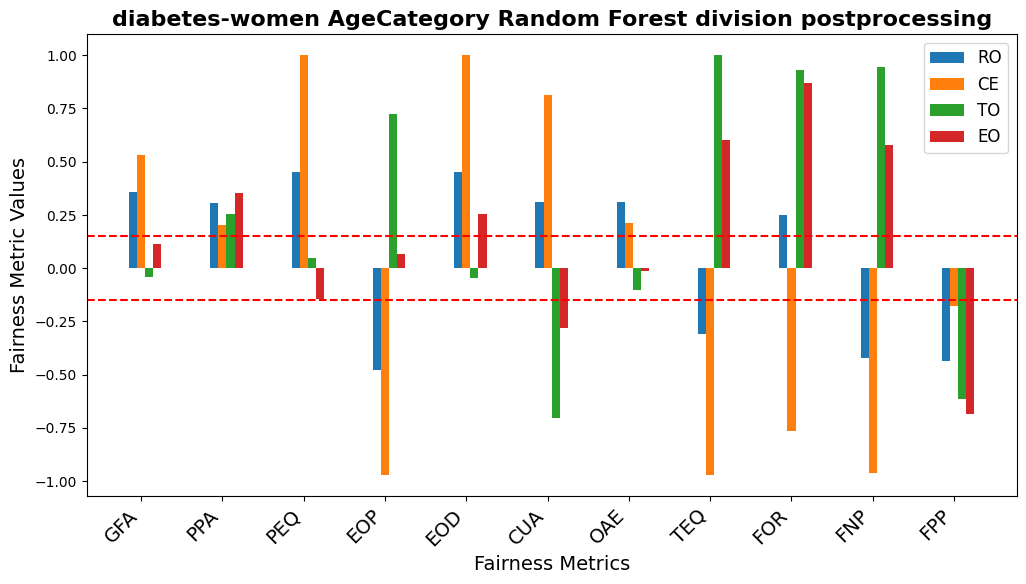

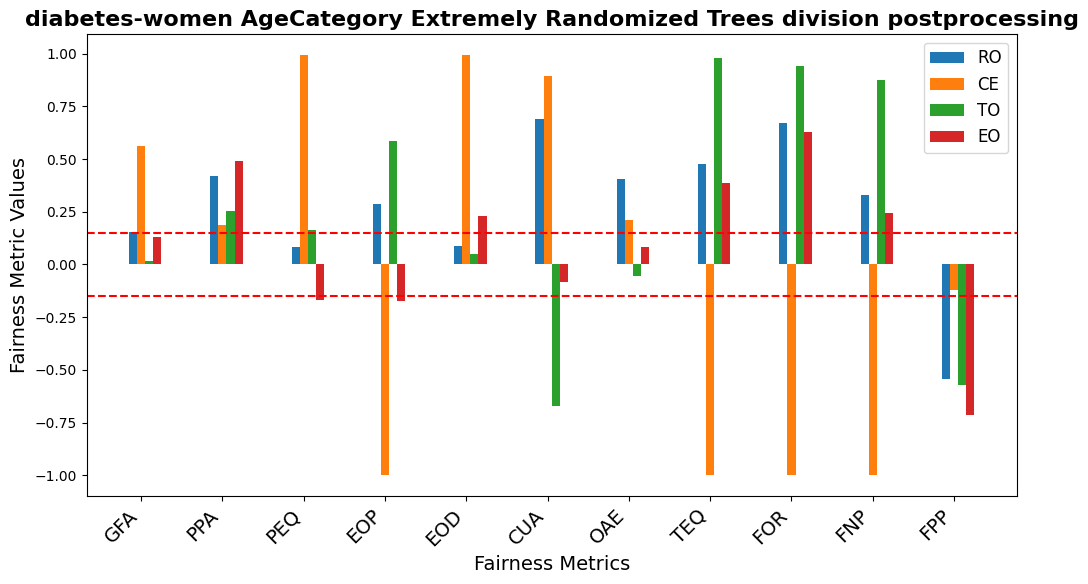

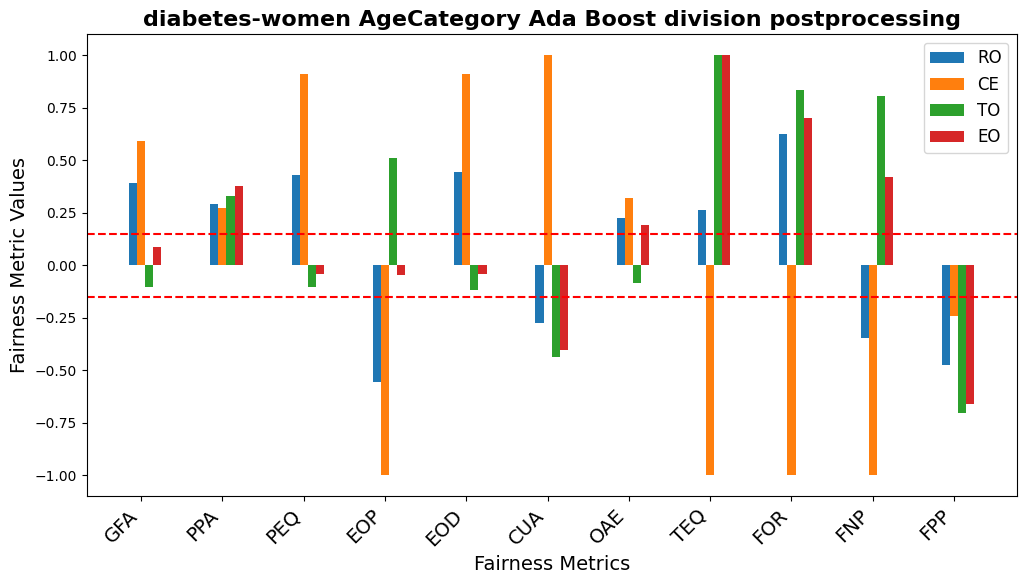

In [ ]:
for dataset_name in dataset_list:
  for sensible_attribute in datasets_config[dataset_name]['sensible_attributes']:
    for m in models:
      grouped_bar(postprocessing_metrics[dataset_name][sensible_attribute], postprocessing_mitigation_list, "division", m, 'postprocessing', dataset_name, sensible_attribute)

### all post-processing techniques, subtraction, all ML models

In [ ]:
for dataset_name in dataset_list:
  for sensible_attribute in datasets_config[dataset_name]['sensible_attributes']:
    for m in models:
      grouped_bar(postprocessing_metrics[dataset_name][sensible_attribute], postprocessing_mitigation_list, "subtraction", m, 'postprocessing', dataset_name, sensible_attribute)

# Extra


## PCA alternative plot, with baseline evidenced.

In [ ]:
# Load the data
data = data_framing(overall_metrics, 'diabetes-women', "division", "Logistic Regression")

pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)

# Select a baseline
baseline_algorithm = 'original'
baseline_index = data.index.get_loc(baseline_algorithm)

# Create a scatter plot
plt.figure(figsize=(10, 6))

for i, algorithm in enumerate(data.index):
    if algorithm == baseline_algorithm:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], c='tab:red', label=algorithm)
    else:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], c='tab:blue', label=algorithm)

# Annotate points with names
for i, algorithm in enumerate(data.index):
    plt.annotate(algorithm, (principal_components[i, 0], principal_components[i, 1]))

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Algorithm Performance with Baseline')

# Add legend
plt.legend()

# TO DO: Distances should be calculated before the PCA
for i, algorithm in enumerate(data.index):
    if algorithm != baseline_algorithm:
        distance = euclidean(principal_components[i], principal_components[baseline_index])
        print(f"Distance between {algorithm} and {baseline_algorithm}: {distance}")

plt.show()

T-SNE experiment alternative to PCA.

In [ ]:
tsne = TSNE(n_components=2, perplexity=3)
X_r = tsne.fit_transform(vectorise(overall_metrics, 'diabetes-women', "division", "Logistic Regression"))

fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']#,'tab:cyan']
ax.scatter(X_r[:, 0], X_r[:, 1], color=colors)
for i, label in enumerate(mitigation_list):
    plt.annotate(label, (X_r[:, 0][i], X_r[:, 1][i]))
plt.show()

## Heatmaps

In [ ]:
# Aggregation of metrics
def aggregate_all(metrics_dictionary, dataset, mitigation, comparison, model):
  l = []
  for metric in metrics:
    l.append(metrics_dictionary[dataset][mitigation][comparison][model][metric]["Value"])
  return np.mean(l), np.std(l)

In [ ]:
# TO DO questo richiede chiaramente che le misure vengano in qualche modo normalizzate o stiano tutte entro lo stesso intervallo e con significati quantitativi simili -> DIFFICILE
aggregate_all(overall_metrics, 'diabetes-women', 'original', "division", "Logistic Regression")

In [ ]:
# Aggregation of metrics by family
def fine_aggregation(metrics_dictionary, dataset, mitigation, comparison, model):
  groups = {'metrics_on_results': ['GroupFairness'],
            'metrics_on_FP': ['PredictiveParity', 'PredictiveEquality', 'FP'],
            'metrics_on_FN': ['EqualOpportunity', 'FORParity', 'FN'],
            'metrics_on_all': ['TreatmentEquality', 'EqualizedOdds', 'ConditionalUseAccuracyEquality', 'OverallAccuracyEquality']
            }

  aggregated_metrics = {}
  for k in groups.keys():
    support = []
    for metric in groups[k]:
      support.append(metrics_dictionary[dataset][mitigation][comparison][model][metric]["Value"])
    aggregated_metrics[k] = np.array([np.mean(support), np.std(support)])

  return aggregated_metrics

In [ ]:
fine_aggregation(overall_metrics, 'diabetes-women', 'original', "division", "Logistic Regression")

In [ ]:
sns.set()
for model in models:
  plt.figure(figsize=(10, 5))
  ax = sns.heatmap(data_framing(overall_metrics, 'diabetes-women', "division", model), annot=True)
  plt.title("Heatmap Fairness Metrics - {}".format(model))
  plt.show()